# Diabetes Case

**"Deteccion de pacientes para ser readmitidos por problemas con diabetes"**

Se carga datasets con información de admisiones a hospitales de enfermos de diabetes. 

El objetivo es, estudiando el historial clínico, cuales de ellos volverán a ser readmitidos al hospital por problemas con la diabetes.

**¿Qué ventajas obtendré resolviendo este problema?**


1. Se reducirá las implicaciones financieras de readmision para los hospitales.
2. Mejorar la experiencia de los pacientes dado que se reducira el retorno no planificado de un paciente al hospital, asi como reducirles gastos por la readmision.
3. Se deja espacio a otros pacientes, dado que por cada paciente readmitido se pierde la oportunidad para tratar a otro paciente que necesite de atención medica.
4. Aumenta la confianza de los pacientes hacia la red 

# Data Understanding Initial

## Cargar Librerias

In [ ]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Definición de funciones

In [ ]:
def cross_target(data,var,target):
    """Calcula los porcentajes de conversión del target por cada categoria de la variable"""
    
    base = data[[var,target]].fillna("NULOS")
    print("----------------------------------------------------------------")
    print("---- Var: ",var)
    print(pd.concat([pd.DataFrame(base[:][var].value_counts(dropna=False).index, columns = ['Atributo']),
           pd.DataFrame(base[:][var].value_counts(dropna=False).values, columns = ['Cantidad']),
           pd.DataFrame(100*base[:][var].value_counts(dropna=False).values/len(base), columns = ['%Total'])], axis = 1))
    
    temp = pd.DataFrame(np.array(base.groupby(var, as_index = False, axis = 0)[target].mean()), 
                         columns = [var,"% ratio_conv"])
    temp["% ratio_conv"] = temp["% ratio_conv"]*100
    temp = temp.sort_values(by = ['% ratio_conv'], ascending = [False])
    print("")
    print(temp)

In [ ]:
def plot_graph_initial(df, meta):
  """Graficos para el analisis univariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(20,5))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if (t.__class__.__name__=="CategoricalDtype"):
          fa=df[v].value_counts() 
          fr=fa/len(df[v]) 
          #Barras
          plt.subplot(1,2,1)
          plt.bar(fa.index,fa)
          plt.xticks(fa.index)
          plt.title(v)
          #Pie
          plt.subplot(1,2,2)
          plt.pie(fr,autopct='%1.1f%%', shadow=True, startangle=90)
          plt.legend(fr.index,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")

      else:
          #Histograma
          plt.subplot(1,2,1)
          plt.hist(df[v].dropna())
          plt.title(v)
          #Boxplot
          plt.subplot(1,2,2)
          plt.boxplot(df[v])
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")
      plt.show()

In [ ]:
def plot_graph_bivariable(df2, meta, y):
  """Graficos para el analisis bivariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(10,5))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if v==y: break
      print(v)
      if (t.__class__.__name__=="CategoricalDtype"):        
          g=df2.groupby([df2[y],v]).size().unstack(0)
          tf= g[1]/(g[0]+g[1])
          c1 = g[0]
          c2 = g[1]
          width = 0.9       # the width of the bars: can also be len(x) sequence

          p1 = plt.bar(g.index, c1, width)
          p2 = plt.bar(g.index, c2, width,
                       bottom=c1)

          plt.ylabel('Freq')
          plt.title('Bivariado')
          plt.xticks(g.index)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      else:
          d=pd.qcut(df2[v], 10, duplicates='drop',labels=False)     
          g=df2.groupby([y, d]).size().unstack(0)   
          N = len(g)
          menMeans = g[0]
          womenMeans = g[1]
          tf= g[1]/(g[0]+g[1])
          ind = np.arange(N)    # the x locations for the groups

          width = 0.9       # the width of the bars: can also be len(x) sequence        
          p1 = plt.bar(ind, menMeans, width)
          p2 = plt.bar(ind, womenMeans, width,
                       bottom=menMeans)

          plt.ylabel('Freq')
          plt.xlabel("Deciles " + v)
          plt.title('Bivariado: ' + v + " vs " + y)
          plt.xticks(ind, np.arange(1,10,1))
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      plt.show()

In [ ]:
def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de missings en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)

In [ ]:
def fx_percentiles_en_lista(lista):
    """Calcula los percentiles y lo muestra en un dataframe"""
    
    vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,99,99.5,100]
    display(pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
                     pd.DataFrame(np.nanpercentile(lista, vector_percentiles), 
                                  columns = ['Valor'])], axis = 1))

In [ ]:
def clean_outlier_perc(df, column, value_perc):
  """Genera el reemplazo de valores outliers superiores por un percentile personalizado"""
  
  top_value = df[column].quantile(value_perc) 
  df.loc[df[column] >= top_value, column] = top_value

In [ ]:
def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [ ]:
def print_mc(matriz_conf):
    """Función para plotear la matriz de confusion"""

    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf) 
    
def fx_evaluate_classif(y_real, pred, pred_proba):
    """Función para las metricas de evaluación de un modelo de clasificacion"""

    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC-AUC: ", roc) 
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

## Lectura y Validacion de datos

IDs Mapping lo he dividido en tres archivos según el tipo de **id** para emplearlo en el análisis

Previamente se revisa el archivo **diabetic_data** y se verifica que tiene valores nulos representados por '?'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta donde se encuentran alojados los datos del caso
url_drive = '/content/drive/MyDrive/Colab Notebooks/case_ds_globant_diabetes/dataset_diabetes/'

In [ ]:
# Carga del dataset **diabetic_data**
dfDiabetes=pd.read_csv(url_drive+'diabetic_data.csv', na_values='?', low_memory=False)

# Carga del dataset **admission_source_id**
dfAdmissionSource=pd.read_csv(url_drive+'admission_source_id.csv')
dfAdmissionSource.rename(columns={'description':'admission_source_desc'},inplace=True)

# Carga del dataset **admission_type_id**
dfAdmissionType=pd.read_csv(url_drive+'admission_type_id.csv')
dfAdmissionType.rename(columns={'description':'admission_type_desc'},inplace=True)

# Carga del dataset **discharge_disposition_id**
dfDischarge=pd.read_csv(url_drive+'discharge_disposition_id.csv')
dfDischarge.rename(columns={'description':'discharge_disposition_desc'},inplace=True)

**Comprobar correcta lectura de los datos**

In [ ]:
dfDiabetes.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
dfAdmissionSource.head(5)

,admission_source_id,admission_source_desc
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [ ]:
dfAdmissionType.head(5)

,admission_type_id,admission_type_desc
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [ ]:
dfDischarge.head(5)

,discharge_disposition_id,discharge_disposition_desc
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


**Descriptivo del Dataset Diabetes**

Se observa que algunas variables como race, weight tienen valores nulos.

In [ ]:
dfDiabetes.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,99493,101766,101766,3197,101766.000000,101766.000000,101766.000000,101766.000000,61510,51817,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101745,101408,100343,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,5,3,10,9,NaN,NaN,NaN,NaN,17,72,NaN,NaN,NaN,NaN,NaN,NaN,716,748,789,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,MC,InternalMedicine,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,76099,54708,26068,1336,NaN,NaN,NaN,NaN,32439,14635,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge datasets

In [ ]:
dfDiabetes = pd.merge(dfDiabetes, dfAdmissionSource, on = 'admission_source_id')
dfDiabetes = pd.merge(dfDiabetes, dfAdmissionType, on = 'admission_type_id')
dfDiabetes = pd.merge(dfDiabetes, dfDischarge, on = 'discharge_disposition_id')
dfDiabetes.drop(columns=['admission_source_id','admission_type_id','discharge_disposition_id'], axis = 1, inplace = True)
dfDiabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
0,2278392,8222157,Caucasian,Female,[0-10),NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,1968528,720936,Caucasian,Female,[70-80),NaN,10,NaN,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,2223336,558360,AfricanAmerican,Female,[60-70),NaN,9,NaN,Orthopedics-Reconstructive,60,5,17,0,0,0,997,8,730,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
3,2298006,2519748,Caucasian,Male,[60-70),NaN,4,NaN,InternalMedicine,47,0,15,0,0,0,486,250,427,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,Physician Referral,None,Not Mapped
4,2356308,608841,AfricanAmerican,Female,[50-60),NaN,1,NaN,Family/GeneralPractice,50,0,8,0,0,0,250.03,401,276,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,Physician Referral,None,Not Mapped


## Estudiar las dimensiones del dataset

In [ ]:
dfDiabetes.shape

(101766, 50)

In [ ]:
dfDiabetes.size

5088300

Cantidad de registros únicos por encounter_id y patient_nbr

In [ ]:
dfDiabetes.encounter_id.nunique()

101766

In [ ]:
dfDiabetes.patient_nbr.nunique()

71518

Se observa que existen más de un **patient_nbr** por cada registro.

La definición de la llave o key es importante en la construcción del modelo supervisado.

## Evaluar el tipo de Problema

**Vemos que es un caso Supervisado donde se trata de un problema de clasificacion para detectar si un paciente va a ser readmitido o no por problemas con diabetes**


## Variable Objetivo

**Armado del target**

En esta base se tiene un caso **multivariado**, tienes 3 salidas diferentes:

*readmitted='NO'  : No readmitido*

*readmitted<30    : Readmitido en < de 30 días*

*readmitted>30    : Readmitido en > de 30 días*


Para el objetivo del problema se ha recategorizado y redefinido el target  a un **bivariado** "readmitted_bin" para intentar resolver las situaciones en las que el paciente no será readmitido.

In [ ]:
dfDiabetes['readmitted_bin'] = dfDiabetes['readmitted'].map({'NO':0, '<30': 1, '>30':1})
dfDiabetes.drop(columns=['readmitted'],axis=1,inplace=True)

In [ ]:
dfDiabetes.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_source_desc,admission_type_desc,discharge_disposition_desc,readmitted_bin
0,2278392,8222157,Caucasian,Female,[0-10),NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Physician Referral,None,Not Mapped,0
1,1968528,720936,Caucasian,Female,[70-80),NaN,10,NaN,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,Physician Referral,None,Not Mapped,1
2,2223336,558360,AfricanAmerican,Female,[60-70),NaN,9,NaN,Orthopedics-Reconstructive,60,5,17,0,0,0,997,8,730,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Physician Referral,None,Not Mapped,0


## Describe Dataset

In [ ]:
dfDiabetes.describe(include ='all')

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_source_desc,admission_type_desc,discharge_disposition_desc,readmitted_bin
count,1.017660e+05,1.017660e+05,99493,101766,101766,3197,101766.000000,61510,51817,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101745,101408,100343,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766.000000
unique,NaN,NaN,5,3,10,9,NaN,17,72,NaN,NaN,NaN,NaN,NaN,NaN,716,748,789,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,17,8,26,NaN
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,MC,InternalMedicine,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Emergency Room,Emergency,Discharged to home,NaN
freq,NaN,NaN,76099,54708,26068,1336,NaN,32439,14635,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,57494,53990,60234,NaN
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.460881
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498470
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


## Renombramiento de variables

In [ ]:
#Renombrado de variables:
dfDiabetes.rename(columns={
   'encounter_id':'idConsulta',
   'patient_nbr':'nbrPaciente',
   'race': 'demoRace',
   'gender': 'demoGender',
   'age': 'demoAge',
   'weight': 'hospWeight',
   'time_in_hospital': 'hospTimeHospital',
   'payer_code': 'hospPayerCode',
   'medical_specialty': 'hospMedicalSpecialty',
   'num_lab_procedures': 'hospNumLabProcedures',
   'num_procedures': 'hospNumProcedures',
   'num_medications': 'hospNumMedications',
   'number_outpatient': 'hospNumOutpatient',
   'number_emergency': 'hospNumEmergency',
   'number_inpatient': 'hospNumInpatient',
   'diag_1': 'diagPrimer',
   'diag_2': 'diagSegundo',
   'diag_3': 'diagTercero',
   'number_diagnoses': 'diagNumDiagnoses',
   'max_glu_serum': 'tratMaxGluSerum',
   'A1Cresult': 'tratA1Cresult',
   'metformin': 'mediMetFormin',
   'repaglinide': 'mediRepaglinide',
   'nateglinide': 'mediNateglinide',
   'chlorpropamide': 'mediChlorpropamide',
   'glimepiride': 'mediGlimepiride',
   'acetohexamide': 'mediAcetohexamide',
   'glipizide': 'mediGlipizide',
   'glyburide': 'mediGlyburide',
   'tolbutamide': 'mediTolbutamide',
   'pioglitazone': 'mediPioglitazone',
   'rosiglitazone': 'mediRosiglitazone',
   'acarbose': 'mediAcarbose',
   'miglitol': 'mediMiglitol',
   'troglitazone': 'mediTroglitazone',
   'tolazamide': 'mediTolazamide',
   'examide': 'mediExamide',
   'citoglipton': 'mediCitoglipton',
   'insulin': 'mediInsulin',
   'glyburide-metformin': 'mediGlyburideMetformin',
   'glipizide-metformin': 'mediGlipizideMetformin',
   'glimepiride-pioglitazone': 'mediGlimepiridePioglitazone',
   'metformin-rosiglitazone': 'mediMetforminRosiglitazone',
   'metformin-pioglitazone': 'mediMetforminPioglitazone',
   'change': 'tratChange',
   'diabetesMed': 'tratDiabetesMed',
   'admission_source_desc': 'descAdmissionSource',
   'admission_type_desc': 'descAdmissionType',
   'discharge_disposition_desc': 'descDischargeDisposition',
   'readmitted_bin': 'target'},inplace=True)

In [ ]:
feat_numerical = [
 'hospTimeHospital',
 'hospNumLabProcedures',
 'hospNumProcedures',
 'hospNumMedications',
 'hospNumOutpatient',
 'hospNumEmergency',
 'hospNumInpatient',
 'diagNumDiagnoses']

Las variables **diagPrimer, DiagSegundo** y **DiagTercero** tienen presencia de valores cualitativos, por tal razón se incluye como una variable categorica

In [ ]:
feat_categorical = [
 'demoRace',
 'demoGender',
 'demoAge',
 'hospWeight',
 'hospPayerCode',
 'hospMedicalSpecialty',
 'diagPrimer',
 'diagSegundo',
 'diagTercero',
 'tratMaxGluSerum',
 'tratA1Cresult',
 'mediMetFormin',
 'mediRepaglinide',
 'mediNateglinide',
 'mediChlorpropamide',
 'mediGlimepiride',
 'mediAcetohexamide',
 'mediGlipizide',
 'mediGlyburide',
 'mediTolbutamide',
 'mediPioglitazone',
 'mediRosiglitazone',
 'mediAcarbose',
 'mediMiglitol',
 'mediTroglitazone',
 'mediTolazamide',
 'mediExamide',
 'mediCitoglipton',
 'mediInsulin',
 'mediGlyburideMetformin',
 'mediGlipizideMetformin',
 'mediGlimepiridePioglitazone',
 'mediMetforminRosiglitazone',
 'mediMetforminPioglitazone',
 'tratChange',
 'tratDiabetesMed',
 'descAdmissionSource',
 'descAdmissionType',
 'descDischargeDisposition',
 'target']

# Data Wrangling

## Analisis Preliminar Univariado

### Formato de columnas

In [ ]:
df_analisis = dfDiabetes.copy()

In [ ]:
for var in feat_categorical:
  df_analisis[var] = df_analisis[var].astype('category')

In [ ]:
v=pd.DataFrame({"variable": df_analisis.columns.values})
t=pd.DataFrame({"tipo": df_analisis.dtypes.values})
meta = pd.concat([v, t], axis=1).iloc[2:,:]
meta

,variable,tipo
2,demoRace,category
3,demoGender,category
4,demoAge,category
5,hospWeight,category
6,hospTimeHospital,int64
7,hospPayerCode,category
8,hospMedicalSpecialty,category
9,hospNumLabProcedures,int64
10,hospNumProcedures,int64
11,hospNumMedications,int64


In [ ]:
plot_graph_initial(df_analisis, meta)

Output hidden; open in https://colab.research.google.com to view.

### Valores Nulos

In [ ]:
fx_porc_missings(dfDiabetes, only_missings=True)

,n_nulos,%Total
demoRace,2273,2.233555
hospWeight,98569,96.858479
hospPayerCode,40256,39.557416
hospMedicalSpecialty,49949,49.082208
diagPrimer,21,0.020636
diagSegundo,358,0.351787
diagTercero,1423,1.398306


In [ ]:
dfDiabetes['demoRace'].fillna('Caucasian', inplace = True) # Moda

dfDiabetes['hospWeight'].fillna('Nulo', inplace = True) # Nueva Clase

dfDiabetes['hospPayerCode'].fillna('Nulo', inplace = True) # Nueva Clase

dfDiabetes['hospMedicalSpecialty'].fillna('Nulo', inplace = True) # Nueva Clase

dfDiabetes['diagPrimer'].fillna(dfDiabetes['diagPrimer'].mode()[0], inplace = True) # Moda

dfDiabetes['diagSegundo'].fillna(dfDiabetes['diagSegundo'].mode()[0], inplace = True) # Moda

dfDiabetes['diagTercero'].fillna('Nulo', inplace = True) # Nueva Clase

In [ ]:
fx_porc_missings(dfDiabetes, only_missings=True)

,n_nulos,%Total


In [ ]:
dfDiabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   idConsulta                   101766 non-null  int64 
 1   nbrPaciente                  101766 non-null  int64 
 2   demoRace                     101766 non-null  object
 3   demoGender                   101766 non-null  object
 4   demoAge                      101766 non-null  object
 5   hospWeight                   101766 non-null  object
 6   hospTimeHospital             101766 non-null  int64 
 7   hospPayerCode                101766 non-null  object
 8   hospMedicalSpecialty         101766 non-null  object
 9   hospNumLabProcedures         101766 non-null  int64 
 10  hospNumProcedures            101766 non-null  int64 
 11  hospNumMedications           101766 non-null  int64 
 12  hospNumOutpatient            101766 non-null  int64 
 13  hospNumEmergen

El **analisis univariado** nos permite evaluar cada variable. Para el caso de "demoRace" vemos que todo se concentra en Caucasian y African y podriamos agrupar Hispanic,Other,Asian; a raiz de esto el siguiente paso seria evaluar esta variable versus el **target** para tomar una decision y tener dos opciones una sin agrupar y otra agrupada dependiendo de la influencia con el target

## Analisis Preliminar Bivariado

In [ ]:
meta

,variable,tipo
2,demoRace,category
3,demoGender,category
4,demoAge,category
5,hospWeight,category
6,hospTimeHospital,int64
7,hospPayerCode,category
8,hospMedicalSpecialty,category
9,hospNumLabProcedures,int64
10,hospNumProcedures,int64
11,hospNumMedications,int64


In [ ]:
df_analisis.groupby(by = ['demoRace']).size()

demoRace
AfricanAmerican    19210
Asian              641  
Caucasian          76099
Hispanic           2037 
Other              1506 
dtype: int64

demoRace


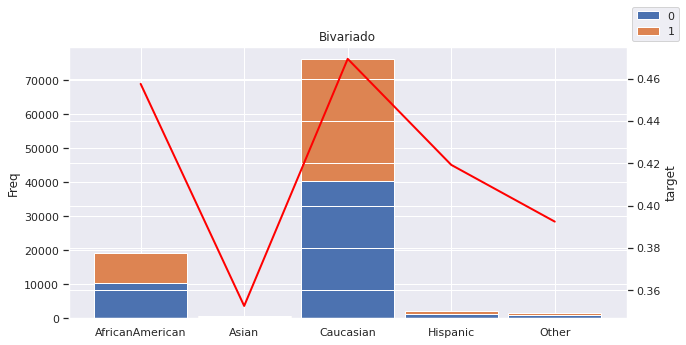

demoGender


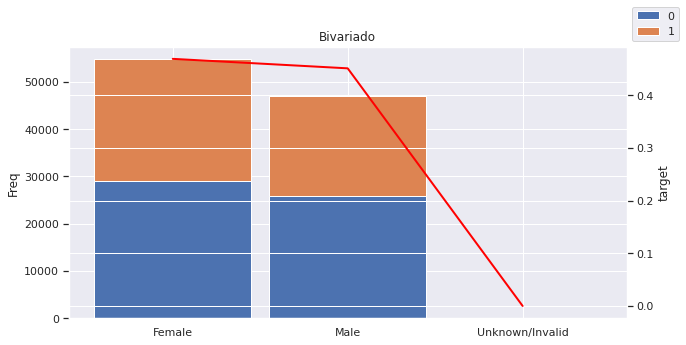

demoAge


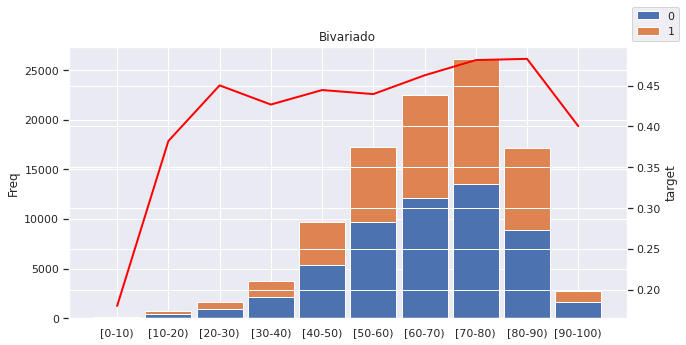

hospWeight


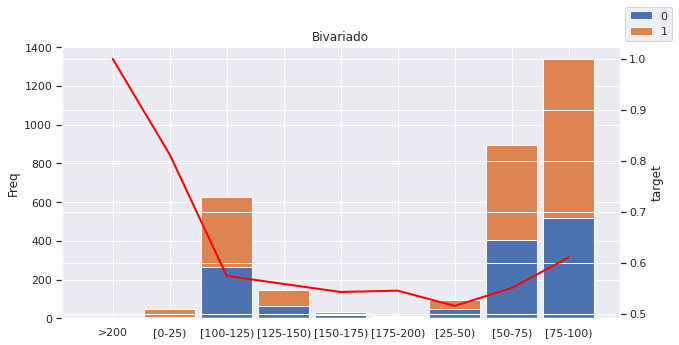

hospTimeHospital


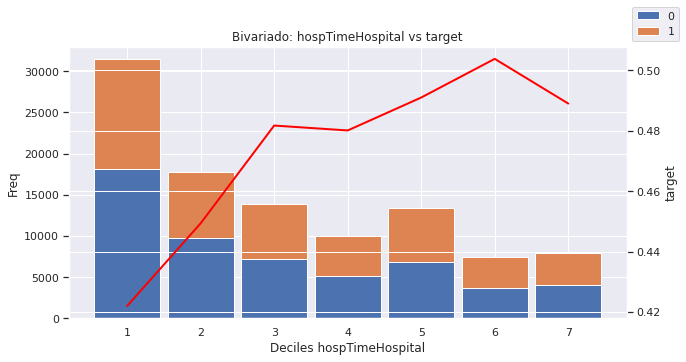

hospPayerCode


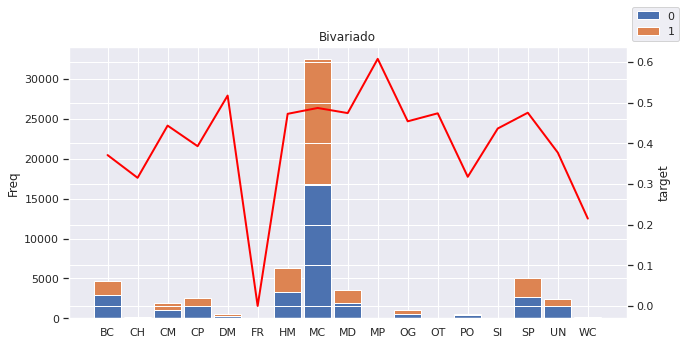

hospMedicalSpecialty


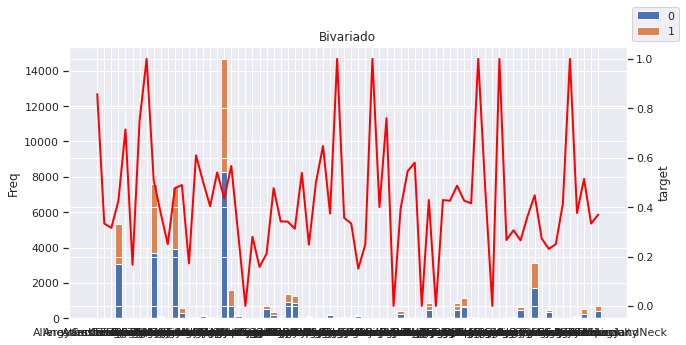

hospNumLabProcedures


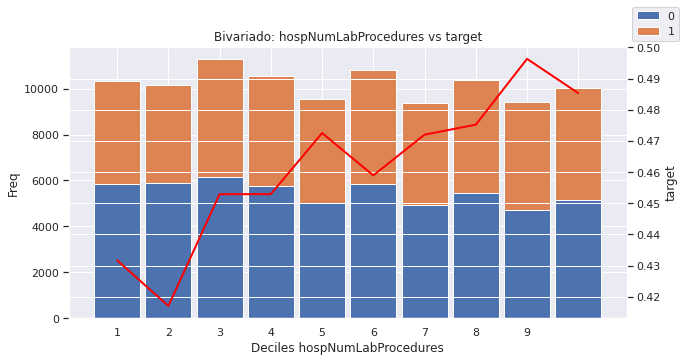

hospNumProcedures


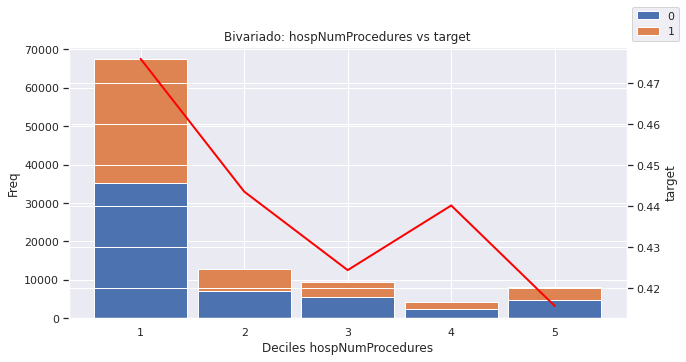

hospNumMedications


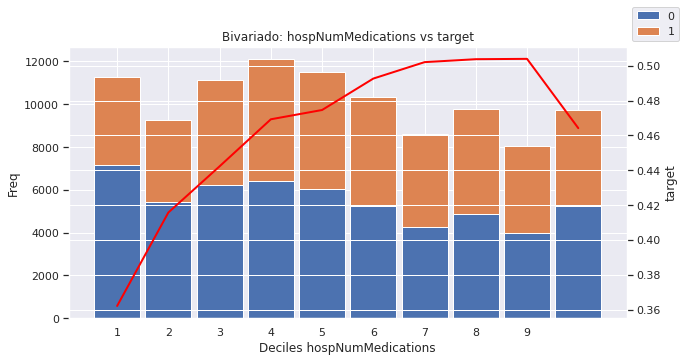

hospNumOutpatient


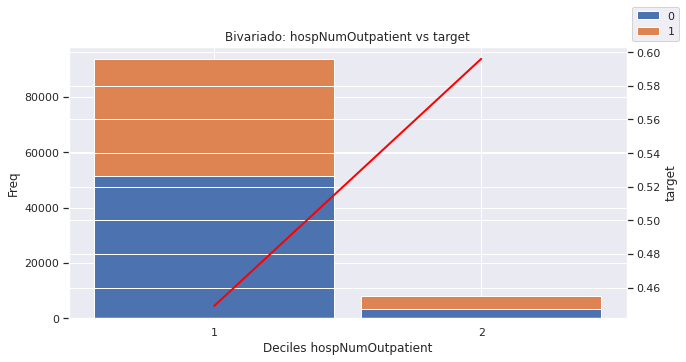

hospNumEmergency


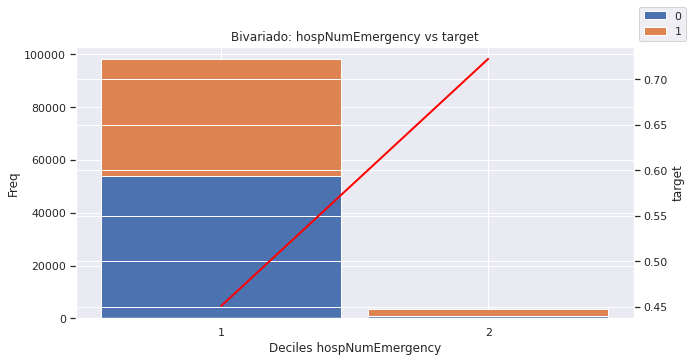

hospNumInpatient


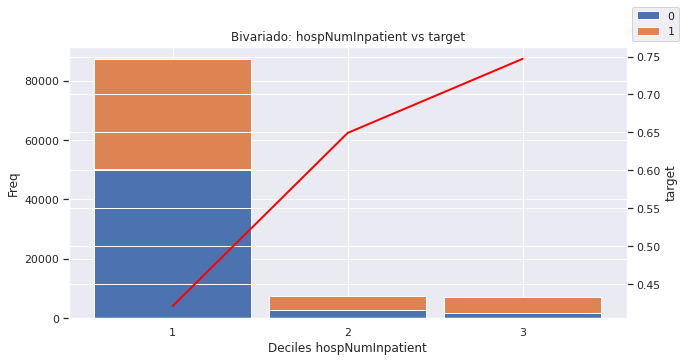

diagPrimer


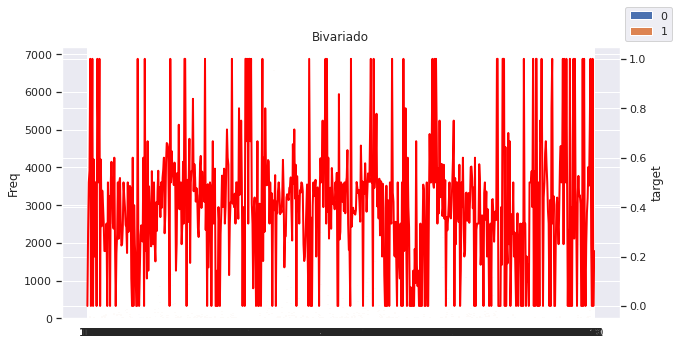

diagSegundo


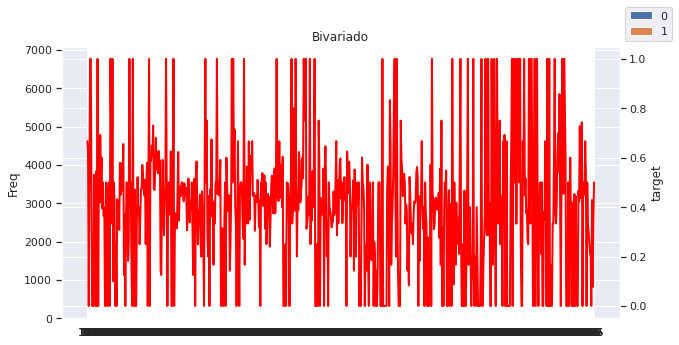

diagTercero


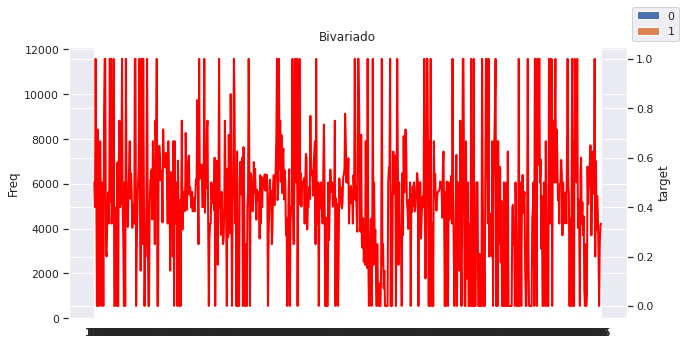

diagNumDiagnoses


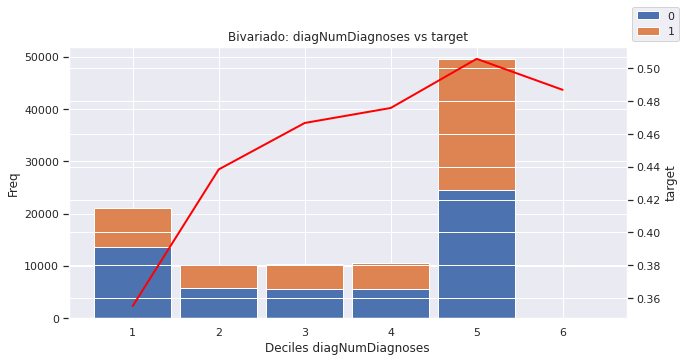

tratMaxGluSerum


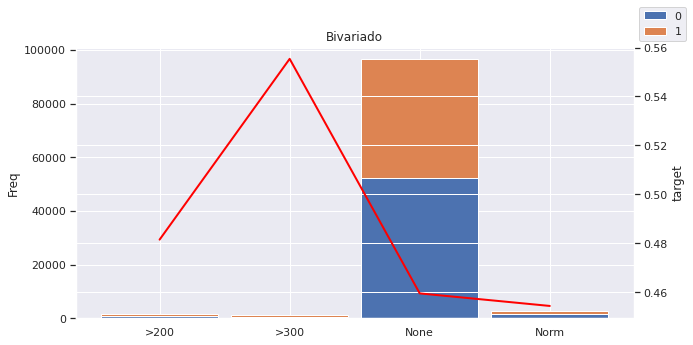

tratA1Cresult


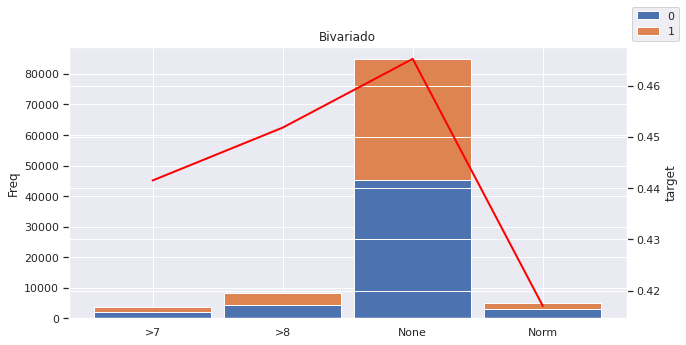

mediMetFormin


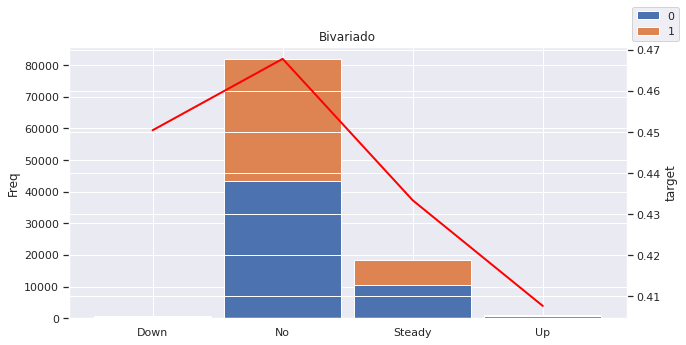

mediRepaglinide


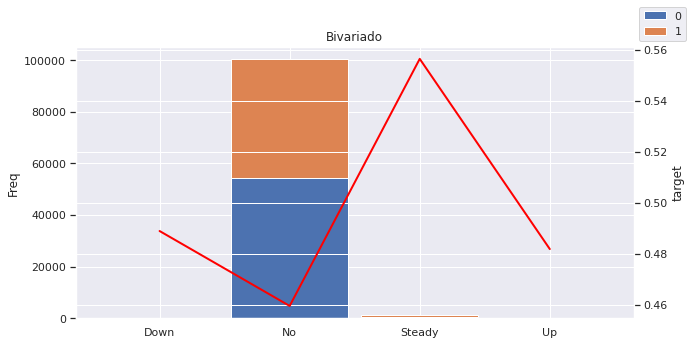

mediNateglinide


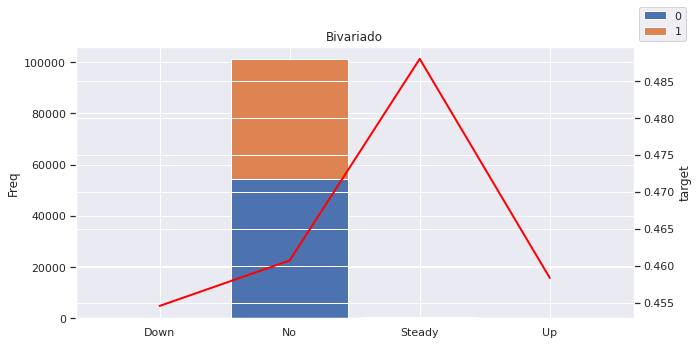

mediChlorpropamide


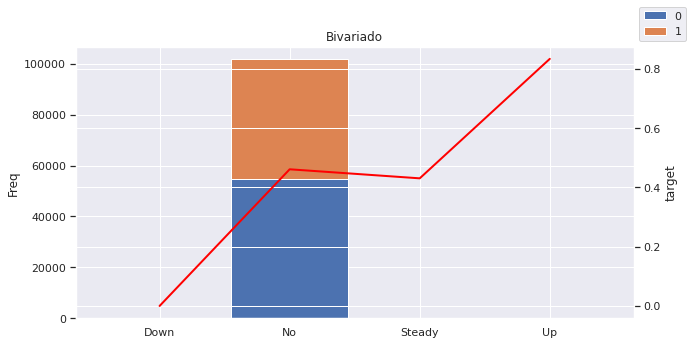

mediGlimepiride


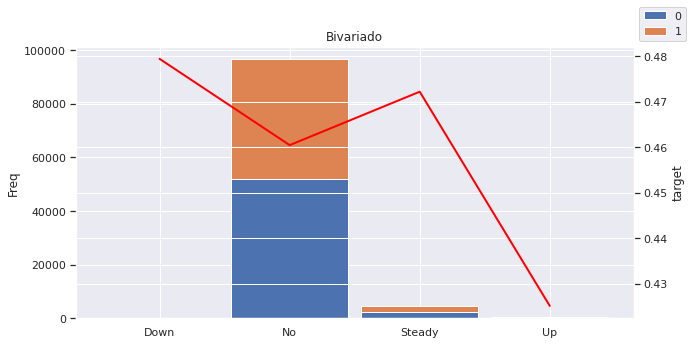

mediAcetohexamide


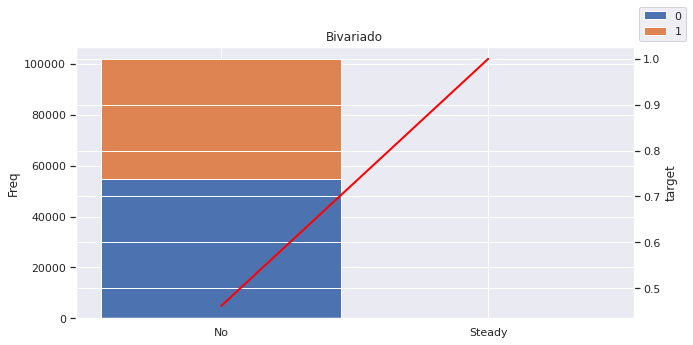

mediGlipizide


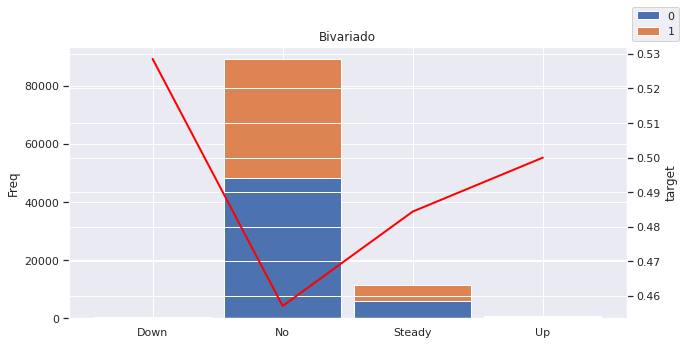

mediGlyburide


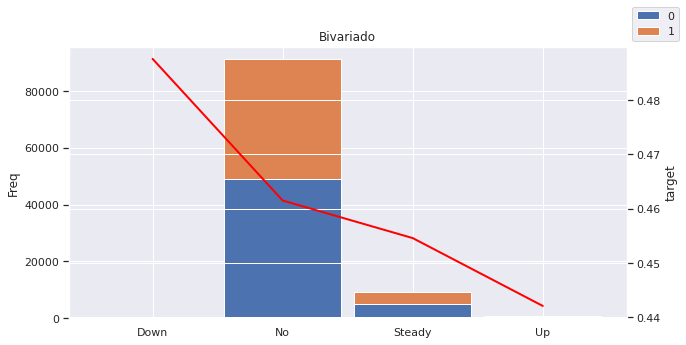

mediTolbutamide


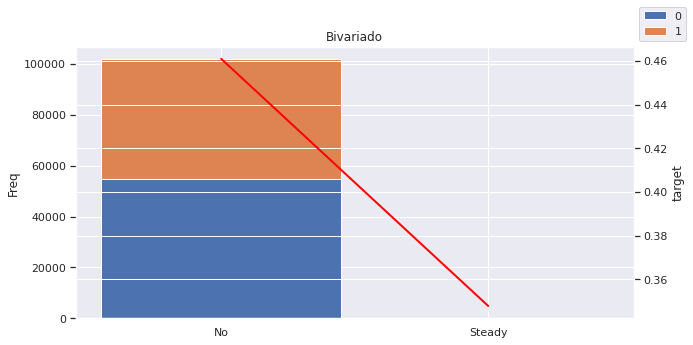

mediPioglitazone


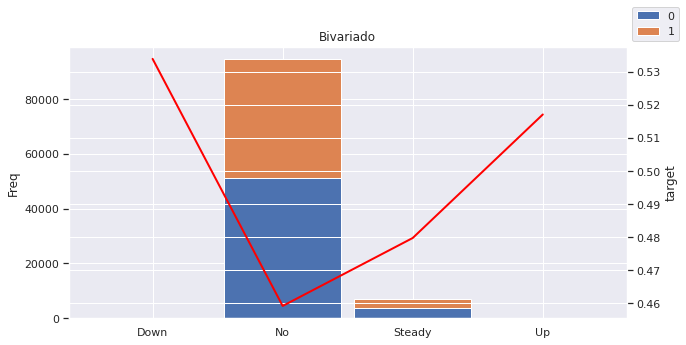

mediRosiglitazone


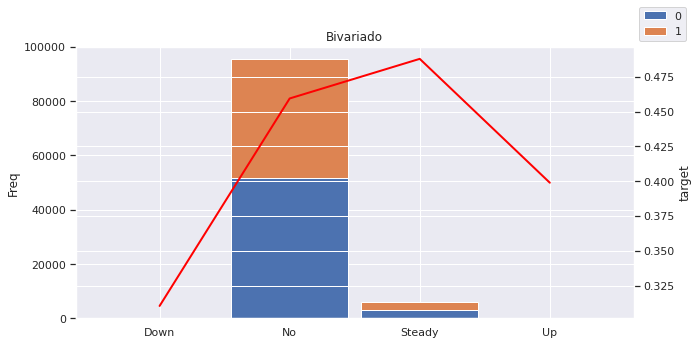

mediAcarbose


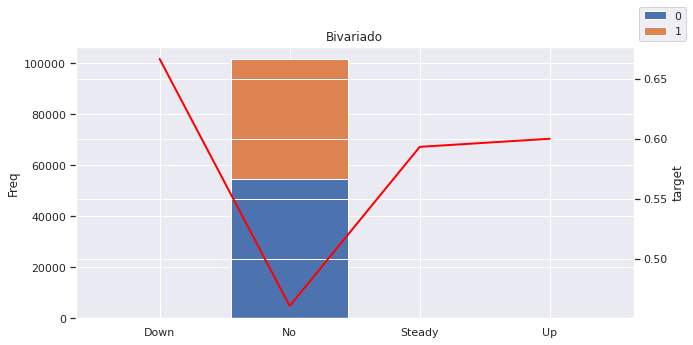

mediMiglitol


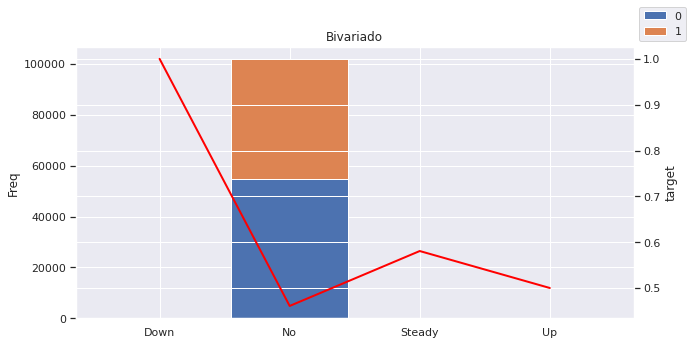

mediTroglitazone


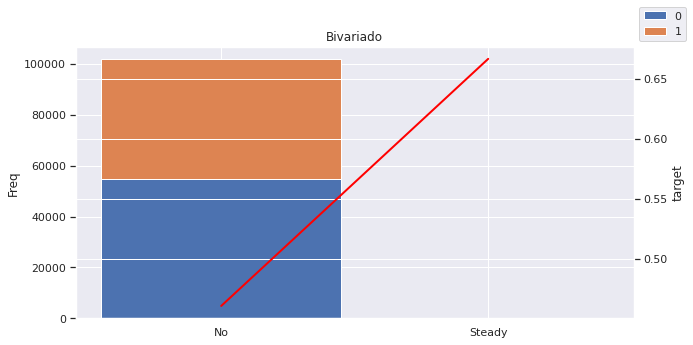

mediTolazamide


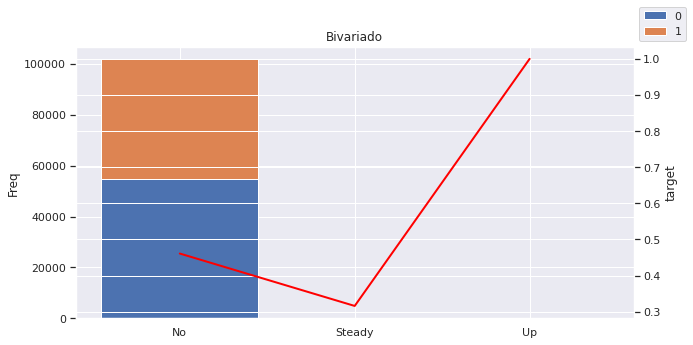

mediExamide


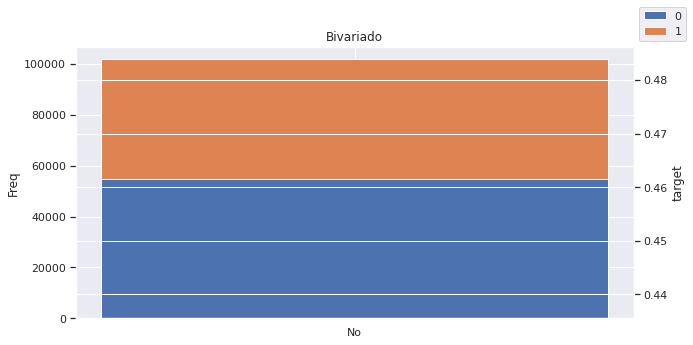

mediCitoglipton


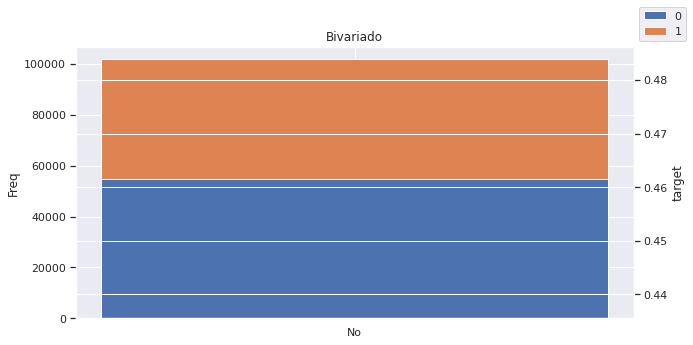

mediInsulin


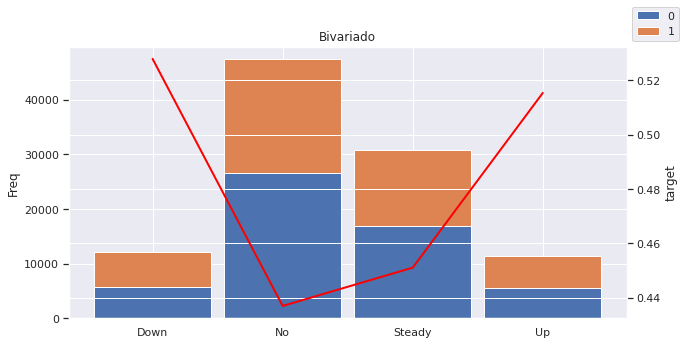

mediGlyburideMetformin


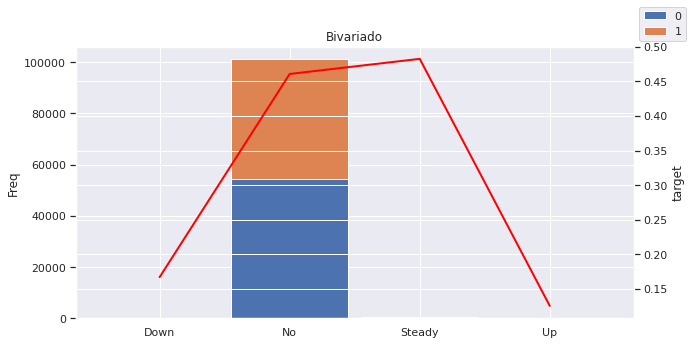

mediGlipizideMetformin


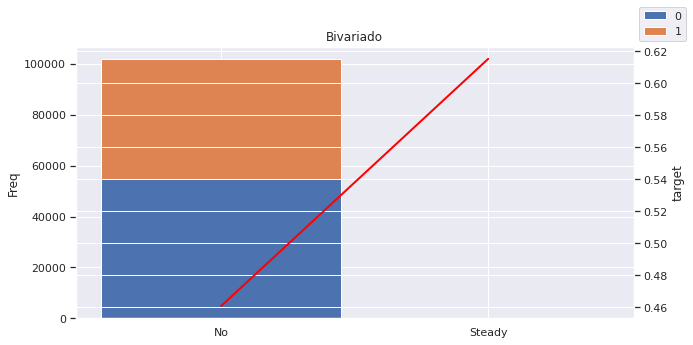

mediGlimepiridePioglitazone


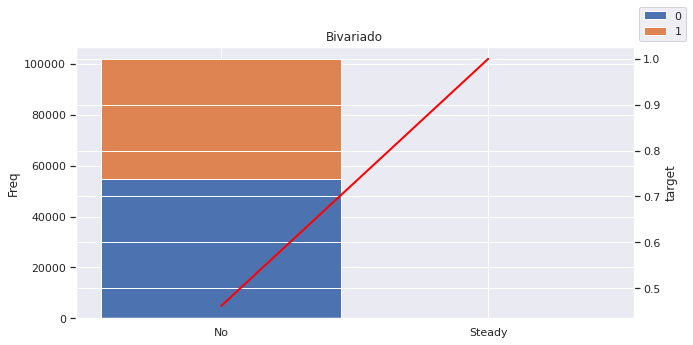

mediMetforminRosiglitazone


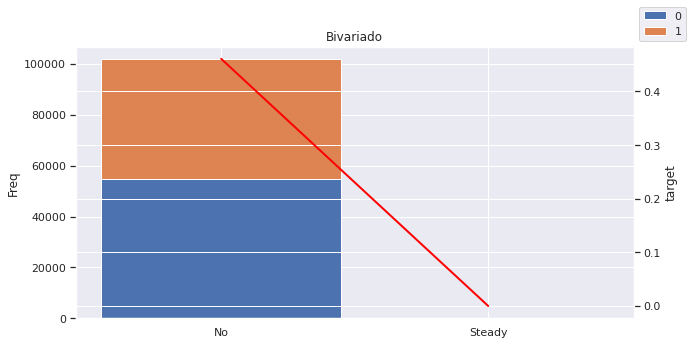

mediMetforminPioglitazone


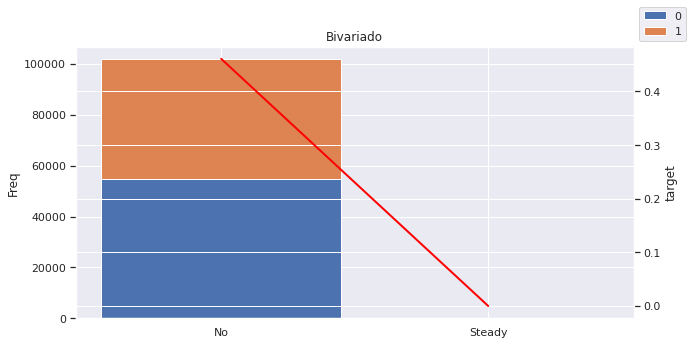

tratChange


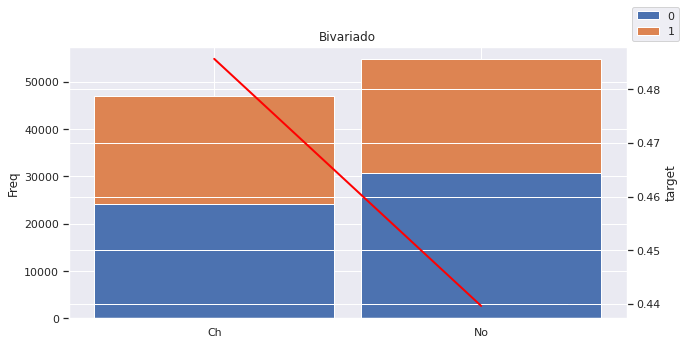

tratDiabetesMed


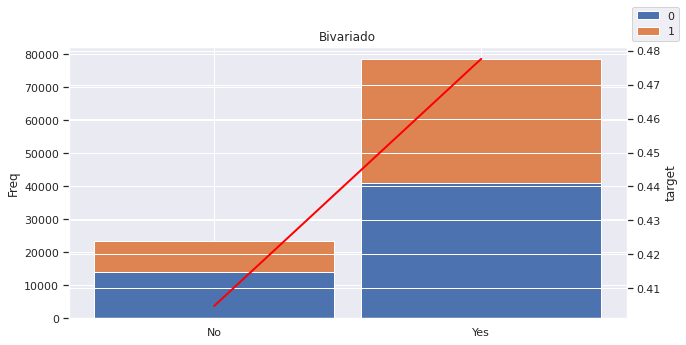

descAdmissionSource


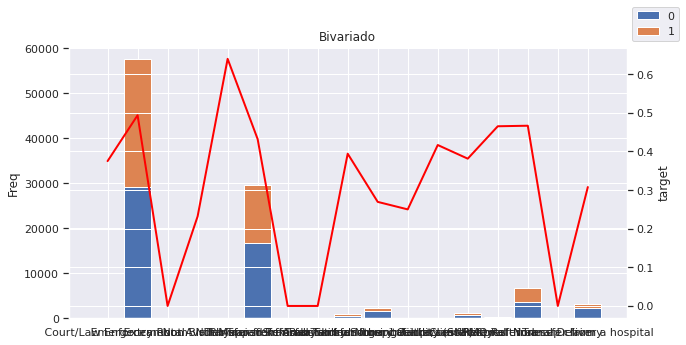

descAdmissionType


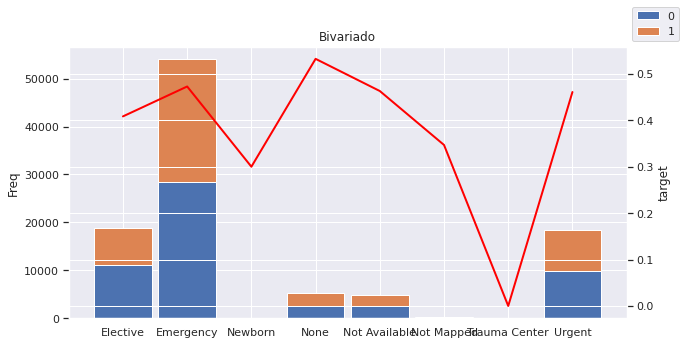

descDischargeDisposition


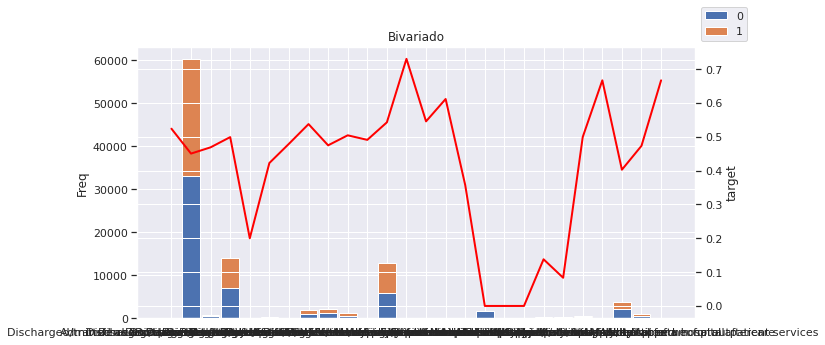

<Figure size 720x360 with 0 Axes>

In [ ]:
plot_graph_bivariable(df_analisis, meta, 'target')

Este análisis nos permite visualizar por tipo categoria de la variable cualitativa y decil de la variable cuantitativa su participación con respecto al target. Esto representa lo que se llama **Target Encoding**. Nos ayudará en saber como podemos agrupar las variables, así como la representatividad con respecto al target de importancia. Por ejemplo en la variable **DemoRace** la categoria **AfricanAmerican** tiene un target encoding de 0.56, siendo muy cercano al **Caucasian** con un valor de 0.47, **apesar de tener menor cantidad de registros**. Este tipo de categoria nos ayudará en mejorar el poder predictivo del modelo.

## Outliers

In [ ]:
dfDiabetes_bkp = dfDiabetes.copy()

In [ ]:
for var in feat_numerical:
  print("Variable: ", var)
  fx_percentiles_en_lista(dfDiabetes[var])

Variable:  hospTimeHospital


,Percentile,Valor
0,0.0,1.0
1,0.5,1.0
2,1.0,1.0
3,2.5,1.0
4,5.0,1.0
5,10.0,1.0
6,25.0,2.0
7,50.0,4.0
8,75.0,6.0
9,90.0,9.0


Variable:  hospNumLabProcedures


,Percentile,Valor
0,0.0,1.0
1,0.5,1.0
2,1.0,1.0
3,2.5,1.0
4,5.0,4.0
5,10.0,14.0
6,25.0,31.0
7,50.0,44.0
8,75.0,57.0
9,90.0,67.0


Variable:  hospNumProcedures


,Percentile,Valor
0,0.0,0.0
1,0.5,0.0
2,1.0,0.0
3,2.5,0.0
4,5.0,0.0
5,10.0,0.0
6,25.0,0.0
7,50.0,1.0
8,75.0,2.0
9,90.0,4.0


Variable:  hospNumMedications


,Percentile,Valor
0,0.0,1.0
1,0.5,2.0
2,1.0,3.0
3,2.5,4.0
4,5.0,6.0
5,10.0,7.0
6,25.0,10.0
7,50.0,15.0
8,75.0,20.0
9,90.0,26.0


Variable:  hospNumOutpatient


,Percentile,Valor
0,0.0,0.0
1,0.5,0.0
2,1.0,0.0
3,2.5,0.0
4,5.0,0.0
5,10.0,0.0
6,25.0,0.0
7,50.0,0.0
8,75.0,0.0
9,90.0,1.0


Variable:  hospNumEmergency


,Percentile,Valor
0,0.0,0.0
1,0.5,0.0
2,1.0,0.0
3,2.5,0.0
4,5.0,0.0
5,10.0,0.0
6,25.0,0.0
7,50.0,0.0
8,75.0,0.0
9,90.0,1.0


Variable:  hospNumInpatient


,Percentile,Valor
0,0.0,0.0
1,0.5,0.0
2,1.0,0.0
3,2.5,0.0
4,5.0,0.0
5,10.0,0.0
6,25.0,0.0
7,50.0,0.0
8,75.0,1.0
9,90.0,2.0


Variable:  diagNumDiagnoses


,Percentile,Valor
0,0.0,1.0
1,0.5,2.0
2,1.0,2.0
3,2.5,3.0
4,5.0,4.0
5,10.0,5.0
6,25.0,6.0
7,50.0,8.0
8,75.0,9.0
9,90.0,9.0


In [ ]:
feat_numerical

['hospTimeHospital',
 'hospNumLabProcedures',
 'hospNumProcedures',
 'hospNumMedications',
 'hospNumOutpatient',
 'hospNumEmergency',
 'hospNumInpatient',
 'diagNumDiagnoses']

Lo que se busca son grandes variaciones por percentil. Por ejemplo para la variable **hospNumEmergency** el **percentil 99** tiene un valor de 3 sin embargo el **percentil 100** tiene un valor 76, es decir solo un 1% concentra valores mayores que 3; se observa una gran variación de un percentil a otro. Este será nuestro criterio para imputar cada variable. 

Se analizaron los **percentiles de cada variable** y se definió en base a ello cómo se iba a imputar para cada caso:

In [ ]:
clean_outlier_perc(dfDiabetes, 'hospNumLabProcedures', 0.95)
clean_outlier_perc(dfDiabetes, 'hospNumMedications', 0.95)
clean_outlier_perc(dfDiabetes, 'hospNumOutpatient', 0.925)
clean_outlier_perc(dfDiabetes, 'hospNumEmergency', 0.925)
clean_outlier_perc(dfDiabetes, 'hospNumInpatient', 0.925)
clean_outlier_perc(dfDiabetes, 'diagNumDiagnoses', 0.925)

**Registros Repetidos**

In [ ]:
g = df_analisis.groupby('idConsulta')

In [ ]:
g.filter(lambda x: len(x) > 1)

,idConsulta,nbrPaciente,demoRace,demoGender,demoAge,hospWeight,hospTimeHospital,hospPayerCode,hospMedicalSpecialty,hospNumLabProcedures,hospNumProcedures,hospNumMedications,hospNumOutpatient,hospNumEmergency,hospNumInpatient,diagPrimer,diagSegundo,diagTercero,diagNumDiagnoses,tratMaxGluSerum,tratA1Cresult,mediMetFormin,mediRepaglinide,mediNateglinide,mediChlorpropamide,mediGlimepiride,mediAcetohexamide,mediGlipizide,mediGlyburide,mediTolbutamide,mediPioglitazone,mediRosiglitazone,mediAcarbose,mediMiglitol,mediTroglitazone,mediTolazamide,mediExamide,mediCitoglipton,mediInsulin,mediGlyburideMetformin,mediGlipizideMetformin,mediGlimepiridePioglitazone,mediMetforminRosiglitazone,mediMetforminPioglitazone,tratChange,tratDiabetesMed,descAdmissionSource,descAdmissionType,descDischargeDisposition,target


El dataset Diabetes a nivel de atencion no presenta duplicados

## Tratamiento de Variables Categoricas

In [ ]:
dataDiabetes = dfDiabetes.copy()

### Agrupando según ratio de Conversión

In [ ]:
# Var: DemoRace
cross_target(dataDiabetes,'demoRace','target')

----------------------------------------------------------------
---- Var:  demoRace
          Atributo  Cantidad     %Total
0  Caucasian        78372     77.011969
1  AfricanAmerican  19210     18.876639
2  Hispanic         2037      2.001651 
3  Other            1506      1.479866 
4  Asian            641       0.629876 

          demoRace % ratio_conv
2  Caucasian        46.4987    
0  AfricanAmerican  45.7522    
3  Hispanic         41.9244    
4  Other            39.243     
1  Asian            35.2574    


In [ ]:
map_demoRace = { 'AfricanAmerican': 'AfricanAmerican',
                 'Caucasian': 'Caucasian',
                 'Asian': 'Others',
                 'Hispanic': 'Others',
                 'Other': 'Others'}

dataDiabetes['demoRace'] = dataDiabetes['demoRace'].map(map_demoRace)

In [ ]:
cross_target(dataDiabetes,'demoRace','target')

----------------------------------------------------------------
---- Var:  demoRace
          Atributo  Cantidad     %Total
0  Caucasian        78372     77.011969
1  AfricanAmerican  19210     18.876639
2  Others           4184      4.111393 

          demoRace % ratio_conv
1  Caucasian        46.4987    
0  AfricanAmerican  45.7522    
2  Others           39.9379    


In [ ]:
# Var: hosWeight
cross_target(dataDiabetes,'hospWeight','target')

----------------------------------------------------------------
---- Var:  hospWeight
    Atributo  Cantidad     %Total
0  Nulo       98569     96.858479
1  [75-100)   1336      1.312816 
2  [50-75)    897       0.881434 
3  [100-125)  625       0.614154 
4  [125-150)  145       0.142484 
5  [25-50)    97        0.095317 
6  [0-25)     48        0.047167 
7  [150-175)  35        0.034393 
8  [175-200)  11        0.010809 
9  >200       3         0.002948 

  hospWeight % ratio_conv
0  >200       100        
2  [0-25)     81.25      
9  [75-100)   61.0778    
3  [100-125)  57.44      
4  [125-150)  55.8621    
8  [50-75)    55.0725    
6  [175-200)  54.5455    
5  [150-175)  54.2857    
7  [25-50)    51.5464    
1  Nulo       45.6888    


In [ ]:
# Var: hospWeight
dicc_hospWeight = {'Nulo': 0, #'Nulo',
 '[0-25)': 1, # '[0 - 75]',
 '[25-50)': 1, # '[0 - 75]',
 '[50-75)': 1, # '[0 - 75]',
 '[75-100)': 2, # '[75 - +]',
 '[100-125)': 2, # '[75 - +]',
 '[125-150)': 2, # '[75 - +]',
 '[150-175)': 2, # '[75 - +]',
 '[175-200)': 2, # '[75 - +]',
 '>200': 2 # '[75 - +]' 
}

dataDiabetes['hospWeight'] = dataDiabetes['hospWeight'].map(dicc_hospWeight)

In [ ]:
cross_target(dataDiabetes,'hospWeight','target')

----------------------------------------------------------------
---- Var:  hospWeight
   Atributo  Cantidad     %Total
0  0         98569     96.858479
1  2         2155      2.117603 
2  1         1042      1.023918 

   hospWeight  % ratio_conv
2  2.0         59.582367   
1  1.0         55.950096   
0  0.0         45.688807   


Teniendo en cuenta que la variable **hospWeight** tiene 96.8% de valores nulos, conviene dejar esta variable libre. Sin embargo, el resto de tipo de categorias conviene agruparlas según su ratio de conversión con respecto al target y el orden de los rangos.

### Aplicando Ordinal Encoder

In [ ]:
dfDiabetes.demoAge.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)     9685 
[30-40)     3775 
[90-100)    2793 
[20-30)     1657 
[10-20)     691  
[0-10)      161  
Name: demoAge, dtype: int64

In [ ]:
# Var: demoAge
from sklearn.preprocessing import OrdinalEncoder
ordEnc = OrdinalEncoder()
dataDiabetes['demoAge'] = ordEnc.fit_transform(dataDiabetes[['demoAge']])

In [ ]:
cross_target(dataDiabetes,'demoAge','target')

----------------------------------------------------------------
---- Var:  demoAge
   Atributo  Cantidad     %Total
0  7.0       26068     25.615628
1  6.0       22483     22.092840
2  5.0       17256     16.956547
3  8.0       17197     16.898571
4  4.0       9685      9.516931 
5  3.0       3775      3.709490 
6  9.0       2793      2.744532 
7  2.0       1657      1.628245 
8  1.0       691       0.679009 
9  0.0       161       0.158206 

   demoAge  % ratio_conv
8  8.0      48.270047   
7  7.0      48.120301   
6  6.0      46.252724   
2  2.0      45.021123   
4  4.0      44.450181   
5  5.0      43.955726   
3  3.0      42.675497   
9  9.0      40.028643   
1  1.0      38.205499   
0  0.0      18.012422   


### Transformacion de Variables Categoricas Nominales a Dummies

In [ ]:
dataDiabetes.shape

(101766, 50)

In [ ]:
vars_str = dataDiabetes.select_dtypes(include=['object']).columns.tolist()
for var in vars_str:
  print("N de",var,":",dataDiabetes[var].nunique())

N de demoRace : 3
N de demoGender : 3
N de hospPayerCode : 18
N de hospMedicalSpecialty : 73
N de diagPrimer : 716
N de diagSegundo : 748
N de diagTercero : 790
N de tratMaxGluSerum : 4
N de tratA1Cresult : 4
N de mediMetFormin : 4
N de mediRepaglinide : 4
N de mediNateglinide : 4
N de mediChlorpropamide : 4
N de mediGlimepiride : 4
N de mediAcetohexamide : 2
N de mediGlipizide : 4
N de mediGlyburide : 4
N de mediTolbutamide : 2
N de mediPioglitazone : 4
N de mediRosiglitazone : 4
N de mediAcarbose : 4
N de mediMiglitol : 4
N de mediTroglitazone : 2
N de mediTolazamide : 3
N de mediExamide : 1
N de mediCitoglipton : 1
N de mediInsulin : 4
N de mediGlyburideMetformin : 4
N de mediGlipizideMetformin : 2
N de mediGlimepiridePioglitazone : 2
N de mediMetforminRosiglitazone : 2
N de mediMetforminPioglitazone : 2
N de tratChange : 2
N de tratDiabetesMed : 2
N de descAdmissionSource : 17
N de descAdmissionType : 8
N de descDischargeDisposition : 26


Se omite las siguientes campos dado que tienen mucha variabilidad (se puede observar que existen demasiadas categorías en las variables) lo cual no ayudaria a hacer alguna distinción con el target:

N de diagPrimer : 716

N de diagSegundo : 748

N de diagTercero : 790

**Si no se desea omitir una alternativa es conversar con el negocio para que nos proporcione un mejor entendiminto de estas variables y asi poder considerarlas.**



In [ ]:
vars_to_dummies = ['demoRace',
 'demoGender',
 'hospPayerCode',
 'hospMedicalSpecialty',
 #'diagPrimer',
 #'diagSegundo',
 #'diagTercero',
 'tratMaxGluSerum',
 'tratA1Cresult',
 'mediMetFormin',
 'mediRepaglinide',
 'mediNateglinide',
 'mediChlorpropamide',
 'mediGlimepiride',
 'mediAcetohexamide',
 'mediGlipizide',
 'mediGlyburide',
 'mediTolbutamide',
 'mediPioglitazone',
 'mediRosiglitazone',
 'mediAcarbose',
 'mediMiglitol',
 'mediTroglitazone',
 'mediTolazamide',
 'mediExamide',
 'mediCitoglipton',
 'mediInsulin',
 'mediGlyburideMetformin',
 'mediGlipizideMetformin',
 'mediGlimepiridePioglitazone',
 'mediMetforminRosiglitazone',
 'mediMetforminPioglitazone',
 'tratChange',
 'tratDiabetesMed',
 'descAdmissionSource',
 'descAdmissionType',
 'descDischargeDisposition']

In [ ]:
dataDiabetes = pd.get_dummies(dataDiabetes, columns = vars_to_dummies)
dataDiabetes.head()

,idConsulta,nbrPaciente,demoAge,hospWeight,hospTimeHospital,hospNumLabProcedures,hospNumProcedures,hospNumMedications,hospNumOutpatient,hospNumEmergency,hospNumInpatient,diagPrimer,diagSegundo,diagTercero,diagNumDiagnoses,target,demoRace_AfricanAmerican,demoRace_Caucasian,demoRace_Others,demoGender_Female,demoGender_Male,demoGender_Unknown/Invalid,hospPayerCode_BC,hospPayerCode_CH,hospPayerCode_CM,hospPayerCode_CP,hospPayerCode_DM,hospPayerCode_FR,hospPayerCode_HM,hospPayerCode_MC,hospPayerCode_MD,hospPayerCode_MP,hospPayerCode_Nulo,hospPayerCode_OG,hospPayerCode_OT,hospPayerCode_PO,hospPayerCode_SI,hospPayerCode_SP,hospPayerCode_UN,hospPayerCode_WC,...,descAdmissionSource_ Transfer from hospital inpt/same fac reslt in a sep claim,descAdmissionSource_Clinic Referral,descAdmissionSource_HMO Referral,descAdmissionSource_None,descAdmissionSource_Normal Delivery,descAdmissionSource_Transfer from a hospital,descAdmissionType_Elective,descAdmissionType_Emergency,descAdmissionType_Newborn,descAdmissionType_None,descAdmissionType_Not Available,descAdmissionType_Not Mapped,descAdmissionType_Trauma Center,descAdmissionType_Urgent,descDischargeDisposition_Admitted as an inpatient to this hospital,descDischargeDisposition_Discharged to home,descDischargeDisposition_Discharged/transferred to ICF,descDischargeDisposition_Discharged/transferred to SNF,descDischargeDisposition_Discharged/transferred to a federal health care facility.,descDischargeDisposition_Discharged/transferred to a long term care hospital.,descDischargeDisposition_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,descDischargeDisposition_Discharged/transferred to another rehab fac including rehab units of a hospital .,descDischargeDisposition_Discharged/transferred to another short term hospital,descDischargeDisposition_Discharged/transferred to another type of inpatient care institution,descDischargeDisposition_Discharged/transferred to home under care of Home IV provider,descDischargeDisposition_Discharged/transferred to home with home health service,descDischargeDisposition_Discharged/transferred within this institution to Medicare approved swing bed,descDischargeDisposition_Discharged/transferred/referred another institution for outpatient services,descDischargeDisposition_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,descDischargeDisposition_Discharged/transferred/referred to this institution for outpatient services,descDischargeDisposition_Expired,"descDischargeDisposition_Expired at home. Medicaid only, hospice.","descDischargeDisposition_Expired in a medical facility. Medicaid only, hospice.",descDischargeDisposition_Hospice / home,descDischargeDisposition_Hospice / medical facility,descDischargeDisposition_Left AMA,descDischargeDisposition_Neonate discharged to another hospital for neonatal aftercare,descDischargeDisposition_None,descDischargeDisposition_Not Mapped,descDischargeDisposition_Still patient or expected to return for outpatient services
0,2278392,8222157,0.0,0,1,41.0,0,1.0,0.0,0.0,0.0,250.83,276,Nulo,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1968528,720936,7.0,0,10,56.0,2,24.0,0.0,0.0,0.0,440,413,250.52,9.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2223336,558360,6.0,0,9,60.0,5,17.0,0.0,0.0,0.0,997,8,730,8.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2298006,2519748,6.0,0,4,47.0,0,15.0,0.0,0.0,0.0,486,250,427,8.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2356308,608841,5.0,0,1,50.0,0,8.0,0.0,0.0,0.0,250.03,401,276,8.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

# Modelado

Seleccionando las variables entre data y target

In [ ]:
var_to_select=list(dataDiabetes.columns)

var_to_select.remove('idConsulta')
var_to_select.remove('nbrPaciente')
var_to_select.remove('target')
var_to_select.remove('diagPrimer')
var_to_select.remove('diagSegundo')
var_to_select.remove('diagTercero')

In [ ]:
list(dataDiabetes.columns)

['idConsulta',
 'nbrPaciente',
 'demoAge',
 'hospWeight',
 'hospTimeHospital',
 'hospNumLabProcedures',
 'hospNumProcedures',
 'hospNumMedications',
 'hospNumOutpatient',
 'hospNumEmergency',
 'hospNumInpatient',
 'diagPrimer',
 'diagSegundo',
 'diagTercero',
 'diagNumDiagnoses',
 'target',
 'demoRace_AfricanAmerican',
 'demoRace_Caucasian',
 'demoRace_Others',
 'demoGender_Female',
 'demoGender_Male',
 'demoGender_Unknown/Invalid',
 'hospPayerCode_BC',
 'hospPayerCode_CH',
 'hospPayerCode_CM',
 'hospPayerCode_CP',
 'hospPayerCode_DM',
 'hospPayerCode_FR',
 'hospPayerCode_HM',
 'hospPayerCode_MC',
 'hospPayerCode_MD',
 'hospPayerCode_MP',
 'hospPayerCode_Nulo',
 'hospPayerCode_OG',
 'hospPayerCode_OT',
 'hospPayerCode_PO',
 'hospPayerCode_SI',
 'hospPayerCode_SP',
 'hospPayerCode_UN',
 'hospPayerCode_WC',
 'hospMedicalSpecialty_AllergyandImmunology',
 'hospMedicalSpecialty_Anesthesiology',
 'hospMedicalSpecialty_Anesthesiology-Pediatric',
 'hospMedicalSpecialty_Cardiology',
 'hospMedic

Se separa la variable dependiente de las variables independientes

In [ ]:
X_data = dataDiabetes[var_to_select]
y_data = dataDiabetes['target']

Se dimensiona el dataset para este modelado inicial 

In [ ]:
X_data.shape

(101766, 241)

## Validación mediante Split Train/Test

Para este ejercicio se utiliza 80% para el train y 20% para el test

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data,
                                                 y_data,
                                                 train_size = 0.8,
                                                 random_state = 20,
                                                 stratify = y_data)

In [ ]:
print("Distribución del Target en el Train: {:0.4}%".format(100*y_train.mean()))
print("Distribución del Target en el Test: {:0.4}%".format(100*y_test.mean()))

Distribución del Target en el Train: 46.09%
Distribución del Target en el Test: 46.09%


## GridSearch y Cross Validation para selección de Variables

Se divide de manera estratificada los datos en k-Fold para evitar que tengan distribuciones desbalanceadas de la clase. Así mismo, se ordenan los datos antes de dividir los datos en K-folds.

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits= 5,shuffle=True, random_state = 49)

Seleccionamos un Random Forest para llevar a cabo esta prueba

In [ ]:
# Grid de hiperparámetros evaluados
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50,100,150],
              'max_features': [20,30,40],
              'max_depth'   : [3,5,8],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 49),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = skf, 
        refit      = True,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=49, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                            

In [ ]:
# Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.drop(columns = 'params',inplace=True)
resultados.sort_values('mean_test_score',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
22,15.408181,0.122930,0.278584,0.010538,gini,8,30,100,0.639993,0.633667,0.635733,0.640216,0.637637,0.637449,0.002506,1,0.646701,0.646901,0.648119,0.645448,0.644926,0.646419,0.001129
48,8.079091,0.198504,0.165491,0.011557,entropy,8,30,50,0.637720,0.633544,0.634934,0.643164,0.636777,0.637228,0.003302,2,0.644337,0.644352,0.645678,0.643528,0.643114,0.644202,0.000878
23,23.135197,0.175772,0.414675,0.010145,gini,8,30,150,0.639317,0.632991,0.634750,0.640646,0.638374,0.637216,0.002879,3,0.646409,0.646870,0.647950,0.645616,0.645033,0.646376,0.001010
49,15.824598,0.417522,0.291153,0.014490,entropy,8,30,100,0.637290,0.634097,0.635426,0.639541,0.638865,0.637044,0.002045,4,0.644014,0.645304,0.646031,0.644235,0.645125,0.644942,0.000736
21,7.769348,0.100692,0.158241,0.006795,gini,8,30,50,0.637843,0.634343,0.635057,0.640953,0.636531,0.636945,0.002340,5,0.644767,0.647776,0.647044,0.644956,0.644450,0.645799,0.001346
20,16.462076,0.127159,0.423501,0.008113,gini,8,20,150,0.637659,0.632930,0.635180,0.641997,0.636900,0.636933,0.003009,6,0.645181,0.646210,0.646614,0.644787,0.645217,0.645602,0.000690
19,11.247495,0.117705,0.277168,0.006782,gini,8,20,100,0.638580,0.631702,0.636531,0.640953,0.636347,0.636823,0.003056,7,0.645749,0.646118,0.646645,0.645417,0.645309,0.645848,0.000489
52,20.230288,0.121402,0.290330,0.017546,entropy,8,40,100,0.637229,0.632930,0.635548,0.640278,0.637575,0.636712,0.002424,8,0.643584,0.644690,0.645248,0.644327,0.644496,0.644469,0.000540
25,19.964809,0.061306,0.281094,0.014486,gini,8,40,100,0.637782,0.632316,0.635057,0.640769,0.636777,0.636540,0.002812,9,0.644920,0.645841,0.646092,0.644757,0.644526,0.645227,0.000622
50,23.538326,0.070755,0.432739,0.011961,entropy,8,30,150,0.636861,0.632562,0.635057,0.639909,0.638251,0.636528,0.002546,10,0.644628,0.645028,0.645647,0.643835,0.644926,0.644813,0.000591


El **accuracy test score** de cada Fold en los cinco primeros registros, son cercanos. El promedio **mean_test_score** a su vez, es muy cercano a los **accuracy test score** de cada Fold, siendo la desviación estandar **std_test_score** muy baja.

Esta nos indica que los datos son consistentes con el algoritmo y sus hiperparametros elegidos, esto nos ayudará en no caer en **Overfitting**

Ahora seleccionemos el mejor modelo que nos ayudará en la selección de variables

In [ ]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores hiperparámetros encontrados (cv)
{'criterion': 'gini', 'max_depth': 8, 'max_features': 30, 'n_estimators': 100} : 0.6374490399257459 accuracy


In [ ]:
# Eligiendo el modelo con el mejor accuracy
model_rf = grid.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(cv = skf,
                           estimator = model_rf,
                           X=X_train,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))
print("Desviación Estandar de los score:", np.std(cross_val))

Todos los scores: [0.63999263 0.63366701 0.63573271 0.64021619 0.63763665]
Promedio de los scores: 0.6374490399257459
Desviación Estandar de los score: 0.002506458416978149


La data esta consistente en sus Fold, los tratamientos aplicados estan conformes. El siguiente paso es seleccionar las variables

**Vamos a entrenar con todo el dataset para obtener la importancia de variables y seleccionar las más importantes.** 

In [ ]:
# Entrenamiento
model_rf_all = model_rf.fit(X_train, y_train)

In [ ]:
#Importancia de las variables
features_rf = pd.DataFrame()
features_rf['variable'] = X_data.columns
features_rf['Importancia'] = model_rf_all.feature_importances_
features_rf.sort_values(by = ['Importancia'],ascending=False,inplace = True)
features_rf.head(15)

,variable,Importancia
8,hospNumInpatient,0.372009
231,descDischargeDisposition_Expired,0.098406
7,hospNumEmergency,0.079517
6,hospNumOutpatient,0.060702
9,diagNumDiagnoses,0.060257
5,hospNumMedications,0.030177
191,descAdmissionSource_ Emergency Room,0.021028
0,demoAge,0.020153
2,hospTimeHospital,0.016369
206,descAdmissionSource_Transfer from a hospital,0.015735


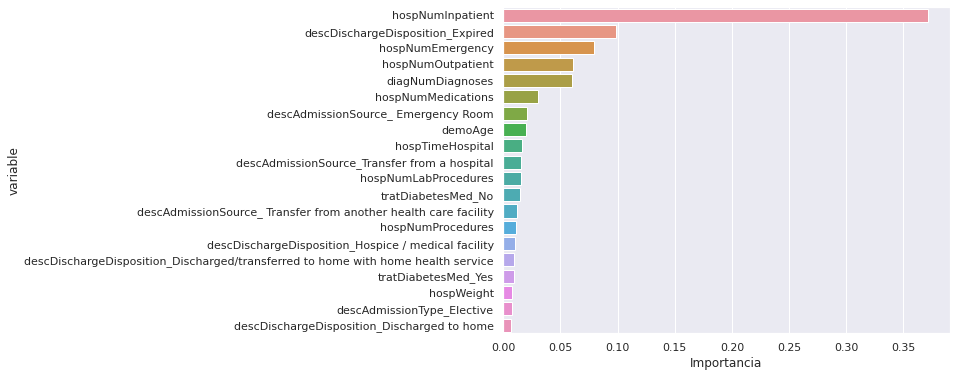

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
sns.barplot(y='variable',x = 'Importancia',data = features_rf.head(20),
           order =features_rf.head(20)['variable'],
           ax=ax)
plt.show()

## Selección de Variables 

In [ ]:
features_mostImportance = list(features_rf.head(9).variable)
features_mostImportance

['hospNumInpatient',
 'descDischargeDisposition_Expired',
 'hospNumEmergency',
 'hospNumOutpatient',
 'diagNumDiagnoses',
 'hospNumMedications',
 'descAdmissionSource_ Emergency Room',
 'demoAge',
 'hospTimeHospital']

In [ ]:
X_train_new = X_train[features_mostImportance]
X_test_new = X_test[features_mostImportance]

X_train_new.reset_index(drop = True, inplace = True)
X_test_new.reset_index(drop = True, inplace = True)

**Redimensionamiento del Train**

In [ ]:
X_train_new.shape

(81412, 9)

## Estandarizacion de Variables Seleccionadas

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_standar = pd.DataFrame(scaler.fit_transform(X_train_new), columns = X_train_new.columns.tolist())
X_test_standar = pd.DataFrame(scaler.fit_transform(X_test_new), columns = X_test_new.columns.tolist())

X_train_standar.head()

,hospNumInpatient,descDischargeDisposition_Expired,hospNumEmergency,hospNumOutpatient,diagNumDiagnoses,hospNumMedications,descAdmissionSource_ Emergency Room,demoAge,hospTimeHospital
0,0.5,0.0,0.0,1.0,1.000,0.300000,1.0,0.777778,0.000000
1,0.5,0.0,0.0,0.0,1.000,0.633333,1.0,0.888889,0.230769
2,1.0,0.0,0.0,1.0,1.000,0.366667,1.0,0.666667,0.307692
3,0.0,0.0,0.0,0.0,0.625,0.266667,0.0,0.555556,0.076923
4,0.0,0.0,0.0,0.0,1.000,0.633333,1.0,0.444444,0.538462


## Análisis de Correlación entre las variables Seleccionadas

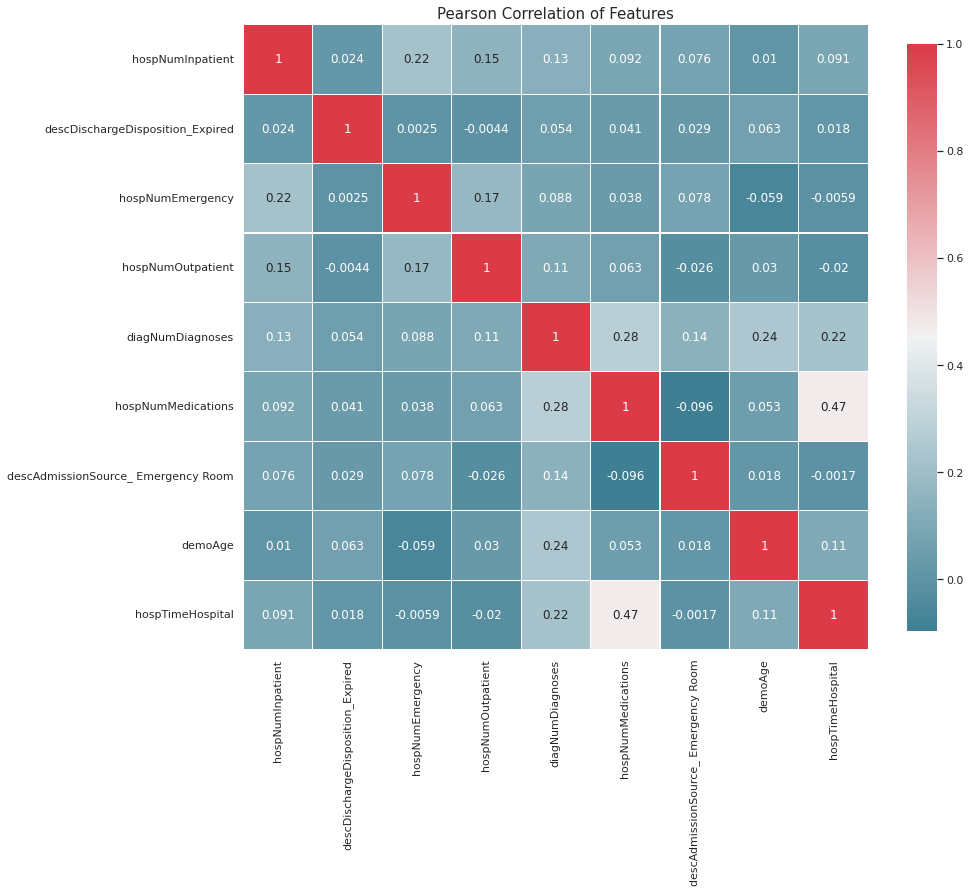

In [ ]:
correlation_heatmap(X_train[features_mostImportance])

Vemos que entre las variables seleccionadas no se encuentra correlación entre ellas por lo que nos quedaremos con todas ellas para el modelo final.

## Entrenamiento y Evaluación de Modelos Finales

In [ ]:
skf = StratifiedKFold(n_splits= 5,shuffle=True, random_state = 49)

### KNN

In [ ]:
# Grid de hiperparámetros evaluados
from sklearn.model_selection import GridSearchCV

param_grid_knn = {'n_neighbors': [6,7,8,9,10,12,15,18,20,25,30], #Number of neighbors to use by default for kneighbors queries
              'weights': ['uniform','distance']
             }

# Búsqueda por grid search con validación cruzada
grid_knn = GridSearchCV(
        estimator  = KNeighborsClassifier(),
        param_grid = param_grid_knn,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = skf, 
        refit      = True,
        return_train_score = True
       )

grid_knn.fit(X = X_train_new, y = y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=49, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [6, 7, 8, 9, 10, 12, 15, 18, 20, 25,
                                         30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [ ]:
# Resultados
resultados_knn = pd.DataFrame(grid_knn.cv_results_)
resultados_knn.drop(columns = 'params',inplace=True)
resultados_knn.sort_values('mean_test_score',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
20,0.415767,0.019341,3.693715,0.054010,30,uniform,0.601548,0.602469,0.596855,0.600049,0.600479,0.600280,0.001909,1,0.634710,0.636383,0.636680,0.634562,0.635713,0.635610,0.000856
18,0.410064,0.007462,3.549246,0.077618,25,uniform,0.600012,0.599030,0.599435,0.596978,0.597101,0.598511,0.001242,2,0.641128,0.643216,0.642407,0.641271,0.643329,0.642270,0.000931
16,0.412940,0.010252,3.448653,0.016903,20,uniform,0.595283,0.596819,0.595996,0.598207,0.593969,0.596055,0.001426,3,0.643124,0.644736,0.644434,0.645678,0.645570,0.644708,0.000924
14,0.418820,0.008453,3.340185,0.057323,18,uniform,0.595222,0.594239,0.595320,0.592433,0.593907,0.594224,0.001049,4,0.645166,0.646594,0.647398,0.647735,0.648503,0.647079,0.001136
12,0.422287,0.007468,3.225378,0.050627,15,uniform,0.590063,0.589511,0.592556,0.589977,0.590898,0.590601,0.001075,5,0.656620,0.656083,0.655259,0.654414,0.658007,0.656077,0.001221
10,0.407960,0.013706,3.147209,0.020007,12,uniform,0.592151,0.589756,0.590529,0.586660,0.585800,0.588979,0.002390,6,0.657173,0.658616,0.657270,0.659389,0.658913,0.658272,0.000893
4,0.418930,0.022752,2.883718,0.027877,8,uniform,0.591292,0.586317,0.586353,0.586783,0.581624,0.586474,0.003062,7,0.670654,0.673064,0.672041,0.672087,0.674743,0.672518,0.001352
8,0.419753,0.012488,2.994002,0.035915,10,uniform,0.588712,0.585212,0.587581,0.585125,0.584449,0.586216,0.001638,8,0.664451,0.665587,0.662828,0.665039,0.665101,0.664601,0.000957
6,0.397813,0.015022,2.856067,0.080465,9,uniform,0.587791,0.582325,0.582177,0.584818,0.579474,0.583317,0.002804,9,0.674983,0.676196,0.673637,0.673990,0.675879,0.674937,0.001006
2,0.426164,0.015034,2.839520,0.048141,7,uniform,0.580421,0.581281,0.578553,0.580887,0.572227,0.578674,0.003356,10,0.685916,0.686100,0.684800,0.686688,0.688270,0.686355,0.001136


In [ ]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print(grid_knn.best_params_, ":", grid_knn.best_score_, grid_knn.scoring)

Mejores hiperparámetros encontrados (cv)
{'n_neighbors': 30, 'weights': 'uniform'} : 0.6002800145380311 accuracy


In [ ]:
# Eligiendo el modelo con el mejor accuracy
model_knn = grid_knn.best_estimator_

In [ ]:
# Validar nuevamente que el modelo tenga estabilidad sobre los datos
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(cv = skf,
                           estimator = model_knn,
                           X=X_train_new,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))
print("Desviación Estandar de los score:", np.std(cross_val))

Todos los scores: [0.60154763 0.60246883 0.59685542 0.60004913 0.60047906]
Promedio de los scores: 0.6002800145380311
Desviación Estandar de los score: 0.0019088485292250172


Es importante tener en cuenta que este algoritmo a pesar de tener baja variabilidad entre los scores obtenidos para cada k-folds. Tener **30 neighbors** no es algo recomendable.

**Entrenamiento con toda la data**

In [ ]:
model_knn_all = model_knn.fit(X_train_new, y_train)

**Evaluación del Modelo**

Se debe de tener en cuenta que para obtener el roc-auc score se debe de realizar el calculo sobre las probabilidades. Se utiliza **predict_proba**

In [ ]:
# Generar las probabilidades
y_pred_proba_train = model_knn_all.predict_proba(X_train_new)[:,1]
y_pred_proba_test = model_knn_all.predict_proba(X_test_new)[:,1]

# Generar las predicciones:
y_pred_train = model_knn_all.predict(X_train_new)
y_pred_test = model_knn_all.predict(X_test_new)

In [ ]:
# Metricas
print("Metricas del Training..." + "\n")
fx_evaluate_classif(y_train, y_pred_train, y_pred_proba_train)
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, y_pred_proba_test)

Metricas del Training...

        Pred_0  Pred_1
Real_0  35245   8646  
Real_1  21048   16473 

ROC-AUC:  0.6871149366109447
Accu: 0.635262614847934 

              precision    recall  f1-score   support

           0       0.63      0.80      0.70     43891
           1       0.66      0.44      0.53     37521

Metricas del Testing...

        Pred_0  Pred_1
Real_0  8461    2512  
Real_1  5590    3791  

ROC-AUC:  0.6319637682255481
Accu: 0.6019455635255969 

              precision    recall  f1-score   support

           0       0.60      0.77      0.68     10973
           1       0.60      0.40      0.48      9381



### Regresión Logística

Para la ejecución de este modelo se utilizan los datos estandarizados **X_train_standar**

In [ ]:
# Grid de hiperparámetros evaluados
from sklearn.model_selection import GridSearchCV

param_grid_reglog = {'C': [0.01,0.1,0.5,1,5,10], #Inverse of regularization strength;
              'penalty': ['none','l1','l2','elasticnet'], #Specify the norm of the penalty;
              'class_weight':['balanced'], #Weights associated with classes in the form {class_label: weight};
              'max_iter':[50,100,200,250,500] #Maximum number of iterations taken for the solvers to converge;
             }

# Búsqueda por grid search con validación cruzada
grid_reglog = GridSearchCV(
        estimator  = LogisticRegression(random_state = 49),
        param_grid = param_grid_reglog,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = skf, 
        refit      = True,
        return_train_score = True
       )

grid_reglog.fit(X = X_train_standar, y = y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=49, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=49, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'class_weight': ['balanced'],
                         'max_iter': [50, 100, 200, 250, 500],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet']},
             pre_dispatch='2*n_jobs',

In [ ]:
# Resultados
resultados_reglog = pd.DataFrame(grid_reglog.cv_results_)
resultados_reglog.drop(columns = 'params',inplace=True)
resultados_reglog.sort_values('mean_test_score',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_penalty,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
18,0.279263,0.011244,0.004845,0.001581,0.01,balanced,500,l2,0.628324,0.625438,0.626397,0.630144,0.629591,0.627979,0.001809,1,0.62843,0.629136,0.628835,0.627622,0.628236,0.628452,0.00052
2,0.293414,0.010356,0.004142,0.000242,0.01,balanced,50,l2,0.628324,0.625438,0.626397,0.630144,0.629591,0.627979,0.001809,1,0.62843,0.629136,0.628835,0.627622,0.628236,0.628452,0.00052
6,0.296736,0.012912,0.004174,0.000177,0.01,balanced,100,l2,0.628324,0.625438,0.626397,0.630144,0.629591,0.627979,0.001809,1,0.62843,0.629136,0.628835,0.627622,0.628236,0.628452,0.00052
10,0.285278,0.010128,0.004289,0.000221,0.01,balanced,200,l2,0.628324,0.625438,0.626397,0.630144,0.629591,0.627979,0.001809,1,0.62843,0.629136,0.628835,0.627622,0.628236,0.628452,0.00052
14,0.278066,0.019394,0.004245,0.000353,0.01,balanced,250,l2,0.628324,0.625438,0.626397,0.630144,0.629591,0.627979,0.001809,1,0.62843,0.629136,0.628835,0.627622,0.628236,0.628452,0.00052


In [ ]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print(grid_reglog.best_params_, ":", grid_reglog.best_score_, grid_reglog.scoring)

Mejores hiperparámetros encontrados (cv)
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'l2'} : 0.6279787033338431 accuracy


Al final obtenemos un modelo con una penalidad **norm ridge**

In [ ]:
# Validar nuevamente que el modelo tenga estabilidad sobre los datos

model_reglog = grid_reglog.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(cv = skf,
                           estimator = model_reglog,
                           X=X_train_standar,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))
print("Desviación Estandar de los score:", np.std(cross_val))

Todos los scores: [0.62832402 0.62543757 0.62639725 0.63014372 0.62959096]
Promedio de los scores: 0.6279787033338431
Desviación Estandar de los score: 0.0018091014095552227


Se puede observar que existe baja variabilidad entre los scores obtenidos para cada k-folds por lo que nos puede asegurar la estabilidad del modelo en todo el dataset. Dado este algoritmo con su conjunto de hiperparámetros, se aplica sobre toda la data de entrenamiento para tener los **parámetros finales**

**Entrenamiento con toda la data**

In [ ]:
model_reglog_all = model_reglog.fit(X_train_standar, y_train)

**Evaluación del Modelo**

In [ ]:
# Generar las probabilidades
y_pred_proba_train = model_reglog_all.predict_proba(X_train_standar)[:,1]
y_pred_proba_test = model_reglog_all.predict_proba(X_test_standar)[:,1]

# Generar las predicciones:
y_pred_train = model_reglog_all.predict(X_train_standar)
y_pred_test = model_reglog_all.predict(X_test_standar)

In [ ]:
# Metricas
print("Metricas del Training..." + "\n")
fx_evaluate_classif(y_train, y_pred_train, y_pred_proba_train)
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, y_pred_proba_test)

Metricas del Training...

        Pred_0  Pred_1
Real_0  31743   12148 
Real_1  18104   19417 

ROC-AUC:  0.6681784466523935
Accu: 0.6284085884144843 

              precision    recall  f1-score   support

           0       0.64      0.72      0.68     43891
           1       0.62      0.52      0.56     37521

Metricas del Testing...

        Pred_0  Pred_1
Real_0  7910    3063  
Real_1  4537    4844  

ROC-AUC:  0.6671961033367819
Accu: 0.6266090203399823 

              precision    recall  f1-score   support

           0       0.64      0.72      0.68     10973
           1       0.61      0.52      0.56      9381



### Decision Tree

In [ ]:
# Grid de hiperparámetros evaluados
from sklearn.model_selection import GridSearchCV

param_grid_dt = { 'max_depth': [3,5,8,10], #The maximum depth of the tree. 
              'criterion': ['gini', 'entropy'], #The function to measure the quality of a split.
              'max_features':[4,6,8], #The number of features to consider when looking for the best split
              'min_samples_split':[5,10,20,30,40,50], #The minimum number of samples required to split an internal node
              'min_samples_leaf':[5,10,20,30,50,50] #The minimum number of samples required to be at a leaf node
             }

# Búsqueda por grid search con validación cruzada
grid_dt = GridSearchCV(
        estimator  = DecisionTreeClassifier(random_state = 49),
        param_grid = param_grid_dt,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = skf, 
        refit      = True,
        return_train_score = True
       )

grid_dt.fit(X = X_train_new, y = y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=49, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=49,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [ ]:
# Resultados
resultados_dt = pd.DataFrame(grid_dt.cv_results_)
resultados_dt.drop(columns = 'params',inplace=True)
resultados_dt.sort_values('mean_test_score',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
684,0.106284,0.004895,0.006624,0.000145,entropy,8,6,5,5,0.630105,0.625376,0.627196,0.632355,0.632048,0.629416,0.002731,1,0.634402,0.634479,0.634362,0.633257,0.634193,0.634139,0.000451
685,0.108417,0.007151,0.006475,0.000194,entropy,8,6,5,10,0.630105,0.625376,0.627196,0.632355,0.632048,0.629416,0.002731,1,0.634402,0.634479,0.634362,0.633257,0.634193,0.634139,0.000451
687,0.105968,0.002451,0.006559,0.000190,entropy,8,6,5,30,0.629122,0.626420,0.627134,0.632478,0.630696,0.629170,0.002235,3,0.633712,0.633619,0.633318,0.632305,0.632566,0.633104,0.000567
704,0.104184,0.005119,0.006924,0.001060,entropy,8,6,30,20,0.629737,0.625315,0.626336,0.632723,0.631433,0.629109,0.002862,4,0.632453,0.633942,0.634285,0.632934,0.632397,0.633202,0.000775
702,0.106979,0.007582,0.007283,0.000981,entropy,8,6,30,5,0.629737,0.625315,0.626336,0.632723,0.631433,0.629109,0.002862,4,0.632453,0.633942,0.634285,0.632934,0.632397,0.633202,0.000775


In [ ]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print(grid_dt.best_params_, ":", grid_dt.best_score_, grid_dt.scoring)

Mejores hiperparámetros encontrados (cv)
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 5} : 0.629415852092167 accuracy


In [ ]:
# Validar nuevamente que el modelo tenga estabilidad sobre los datos
model_dt = grid_dt.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(cv = skf,
                           estimator = model_dt,
                           X=X_train_new,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))
print("Desviación Estandar de los score:", np.std(cross_val))

Todos los scores: [0.63010502 0.62537616 0.62719568 0.63235475 0.63204766]
Promedio de los scores: 0.629415852092167
Desviación Estandar de los score: 0.00273081556287059


Se puede observar que existe baja variabilidad entre los scores obtenidos para cada k-folds por lo que nos puede asegurar la estabilidad del modelo en todo el dataset. Dado este algoritmo con su conjunto de hiperparámetros, se aplica sobre toda la data de entrenamiento para tener los **parámetros finales**

**Entrenamiento con toda la data**

In [ ]:
model_dt_all = model_dt.fit(X_train_new, y_train)

**Evaluación del Modelo**

In [ ]:
# Generar las probabilidades
y_pred_proba_train = model_dt_all.predict_proba(X_train_new)[:,1]
y_pred_proba_test = model_dt_all.predict_proba(X_test_new)[:,1]

# Generar las predicciones:
y_pred_train = model_dt_all.predict(X_train_new)
y_pred_test = model_dt_all.predict(X_test_new)

In [ ]:
# Métricas
print("Metricas del Training..." + "\n")
fx_evaluate_classif(y_train, y_pred_train, y_pred_proba_train)
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, y_pred_proba_test)

Metricas del Training...

        Pred_0  Pred_1
Real_0  32977   10914 
Real_1  18885   18636 

ROC-AUC:  0.6776766790157484
Accu: 0.6339728786911021 

              precision    recall  f1-score   support

           0       0.64      0.75      0.69     43891
           1       0.63      0.50      0.56     37521

Metricas del Testing...

        Pred_0  Pred_1
Real_0  8136    2837  
Real_1  4812    4569  

ROC-AUC:  0.6679233440906152
Accu: 0.6242016311290164 

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     10973
           1       0.62      0.49      0.54      9381



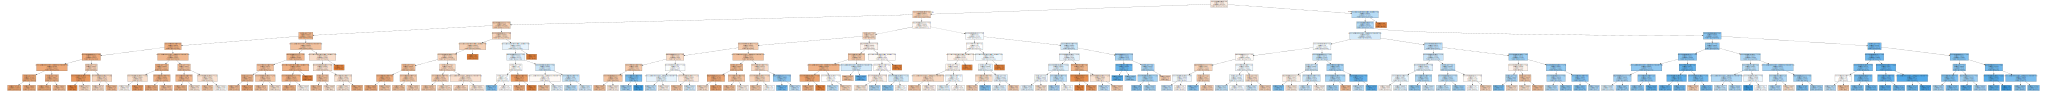

In [ ]:
# Plot del arbol
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

graph = Source(export_graphviz(model_dt_all,out_file=None,
                               feature_names=X_train_new.columns.values,
                              filled=True))
SVG(graph.pipe(format='svg'))

### Random Forest

In [ ]:
# Validar nuevamente que el modelo tenga estabilidad sobre los datos

model_rf = RandomForestClassifier(n_estimators=500, #The number of trees in the forest.
                                 max_depth = 6, #The maximum depth of the tree. 
                                 max_features = 8, #The number of features to consider when looking for the best split
                                 criterion ='entropy', #The function to measure the quality of a split.
                                 min_samples_split = 8, #The minimum number of samples required to split an internal node
                                 min_samples_leaf =10, ##The minimum number of samples required to be at a leaf node
                                 random_state = 49,
                                 class_weight='balanced')

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(cv = skf,
                           estimator = model_rf,
                           X=X_train_new,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))
print("Desviación Estandar de los score:", np.std(cross_val))

Todos los scores: [0.62899957 0.62703433 0.62860828 0.63315318 0.63155632]
Promedio de los scores: 0.6298703349232234
Desviación Estandar de los score: 0.00219150745825216


Se puede observar que existe baja variabilidad entre los scores obtenidos para cada k-folds por lo que nos puede asegurar la estabilidad del modelo en todo el dataset. Dado este algoritmo con su conjunto de hiperparámetros, se aplica sobre toda la data de entrenamiento para tener los **parámetros finales**

**Entrenamiento con toda la data**

In [ ]:
model_rf_all = model_rf.fit(X_train_new, y_train)

**Evaluación del Modelo**

In [ ]:
# Generar las probabilidades
y_pred_proba_train = model_rf_all.predict_proba(X_train_new)[:,1]
y_pred_proba_test = model_rf_all.predict_proba(X_test_new)[:,1]

# Generar las predicciones:
y_pred_train = model_rf_all.predict(X_train_new)
y_pred_test = model_rf_all.predict(X_test_new)

In [ ]:
# Métricas
print("Metricas del Training..." + "\n")
fx_evaluate_classif(y_train, y_pred_train, y_pred_proba_train)
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, y_pred_proba_test)

Metricas del Training...

        Pred_0  Pred_1
Real_0  31353   12538 
Real_1  17517   20004 

ROC-AUC:  0.6740378330651524
Accu: 0.6308283791087309 

              precision    recall  f1-score   support

           0       0.64      0.71      0.68     43891
           1       0.61      0.53      0.57     37521

Metricas del Testing...

        Pred_0  Pred_1
Real_0  7793    3180  
Real_1  4408    4973  

ROC-AUC:  0.6716339617920208
Accu: 0.6271985850447087 

              precision    recall  f1-score   support

           0       0.64      0.71      0.67     10973
           1       0.61      0.53      0.57      9381



### XGBoost

Utilizamos el XGBoost, asi creamos varios arboles y cada uno de ellos va aprendiendo de los errores del otro.


In [ ]:
model_xgb = xgb.XGBClassifier(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.1,
                    eval_metric=['auc','error'],
                    objective='binary:logistic',
                    random_state=49)

In [ ]:
# if more than one evaluation metric are given the last one is used for early stopping
model_xgb.fit(X_train_new, y_train, 
              early_stopping_rounds=5, 
              eval_set=[(X_test_new, y_test)])

y_pred = model_xgb.predict(X_test_new)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.667018	validation_0-error:0.374226
Multiple eval metrics have been passed: 'validation_0-error' will be used for early stopping.

Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-auc:0.668679	validation_0-error:0.372801
[2]	validation_0-auc:0.669198	validation_0-error:0.371671
[3]	validation_0-auc:0.669671	validation_0-error:0.371819
[4]	validation_0-auc:0.670936	validation_0-error:0.371622
[5]	validation_0-auc:0.671704	validation_0-error:0.371131
[6]	validation_0-auc:0.672559	validation_0-error:0.371868
[7]	validation_0-auc:0.67275	validation_0-error:0.371966
[8]	validation_0-auc:0.673218	validation_0-error:0.372212
[9]	validation_0-auc:0.673123	validation_0-error:0.371721
[10]	validation_0-auc:0.673067	validation_0-error:0.371573
Stopping. Best iteration:
[5]	validation_0-auc:0.671704	validation_0-error:0.371131



0.6288690183747666

## Modelo Final

**Entrenamiento**

In [ ]:
model_rf = RandomForestClassifier(n_estimators=500, #The number of trees in the forest.
                                 max_depth = 6, #The maximum depth of the tree. 
                                 max_features = 8, #The number of features to consider when looking for the best split
                                 criterion ='entropy', #The function to measure the quality of a split.
                                 min_samples_split = 8, #The minimum number of samples required to split an internal node
                                 min_samples_leaf =10, ##The minimum number of samples required to be at a leaf node
                                 random_state = 49,
                                 class_weight='balanced')

In [ ]:
model_rf = model_rf.fit(X_train_new, y_train)

In [ ]:
#Importancia de las variables

features_rf = pd.DataFrame()
features_rf['variable'] = X_train_new.columns
features_rf['Importancia'] = model_rf.feature_importances_
features_rf.sort_values(by = ['Importancia'],ascending=False,inplace = True)
features_rf.head(15)

,variable,Importancia
0,hospNumInpatient,0.526394
1,descDischargeDisposition_Expired,0.214103
4,diagNumDiagnoses,0.083074
2,hospNumEmergency,0.050922
7,demoAge,0.042289
3,hospNumOutpatient,0.039450
6,descAdmissionSource_ Emergency Room,0.022934
5,hospNumMedications,0.013353
8,hospTimeHospital,0.007481


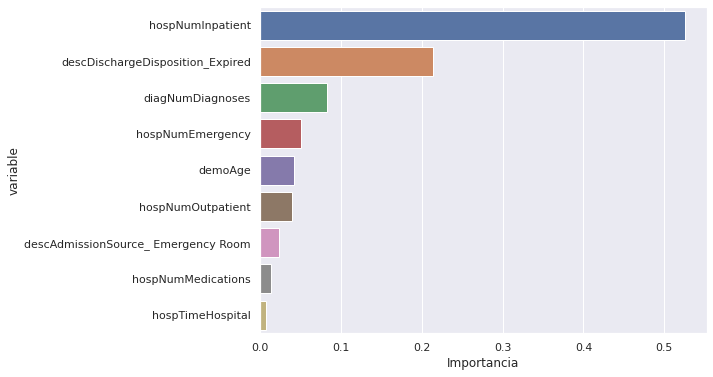

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
sns.barplot(y='variable',x = 'Importancia',data = features_rf.head(20),
           order =features_rf.head(20)['variable'],
           ax=ax)

**Evaluacion del Modelo**

In [ ]:
# Generar las probabilidades
y_pred_proba_train = model_rf.predict_proba(X_train_new)[:,1]
y_pred_proba_test = model_rf.predict_proba(X_test_new)[:,1]

# Generar las predicciones:
y_pred_train = model_rf.predict(X_train_new)
y_pred_test = model_rf.predict(X_test_new)

In [ ]:
print("Metricas del Training..." + "\n")
fx_evaluate_classif(y_train, y_pred_train, y_pred_proba_train)
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, y_pred_proba_test)

Metricas del Training...

        Pred_0  Pred_1
Real_0  31353   12538 
Real_1  17517   20004 

ROC-AUC:  0.6740378330651524
Accu: 0.6308283791087309 

              precision    recall  f1-score   support

           0       0.64      0.71      0.68     43891
           1       0.61      0.53      0.57     37521

Metricas del Testing...

        Pred_0  Pred_1
Real_0  7793    3180  
Real_1  4408    4973  

ROC-AUC:  0.6716339617920208
Accu: 0.6271985850447087 

              precision    recall  f1-score   support

           0       0.64      0.71      0.67     10973
           1       0.61      0.53      0.57      9381



Se tiene los siguientes valores con respecto al Test:

Accuracy: **0.6271** 

Área bajo la curva (ROC-AUC): **0.6716**

Es el algoritmo con que brinda los valores más altos con respecto a KNN, Regresión Logistica y XGBoost

# Analisis Post Modelamiento

In [ ]:
feas = ['hospNumInpatient',
 'descDischargeDisposition',
 'hospNumEmergency',
 'hospNumOutpatient',
 'diagNumDiagnoses',
 'hospNumMedications',
 'descAdmissionSource',
 'hospTimeHospital',
 'demoAge',
 'tratDiabetesMed',
 'target']

In [ ]:
dfAnalisis = dfDiabetes[feas]
dfAnalisis.head()

,hospNumInpatient,descDischargeDisposition,hospNumEmergency,hospNumOutpatient,diagNumDiagnoses,hospNumMedications,descAdmissionSource,hospTimeHospital,demoAge,tratDiabetesMed,target
0,0.0,Not Mapped,0.0,0.0,1.0,1.0,Physician Referral,1,[0-10),No,0
1,0.0,Not Mapped,0.0,0.0,9.0,24.0,Physician Referral,10,[70-80),Yes,1
2,0.0,Not Mapped,0.0,0.0,8.0,17.0,Physician Referral,9,[60-70),No,0
3,0.0,Not Mapped,0.0,0.0,8.0,15.0,Physician Referral,4,[60-70),Yes,0
4,0.0,Not Mapped,0.0,0.0,8.0,8.0,Physician Referral,1,[50-60),Yes,1


In [ ]:
fea_to_catg = dfAnalisis.select_dtypes(include='object').columns.tolist()
fea_to_catg.append('target')

for var in fea_to_catg:
  dfAnalisis[var] = dfAnalisis[var].astype('category') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
v=pd.DataFrame({"variable": dfAnalisis.columns.values})
t=pd.DataFrame({"tipo": dfAnalisis.dtypes.values})
meta = pd.concat([v, t], axis=1).iloc[2:,:]
print(meta)

               variable      tipo
2   hospNumEmergency     float64 
3   hospNumOutpatient    float64 
4   diagNumDiagnoses     float64 
5   hospNumMedications   float64 
6   descAdmissionSource  category
7   hospTimeHospital     int64   
8   demoAge              category
9   tratDiabetesMed      category
10  target               category


hospNumEmergency


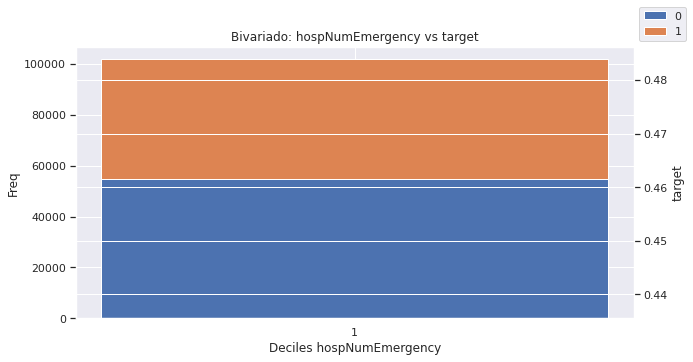

hospNumOutpatient


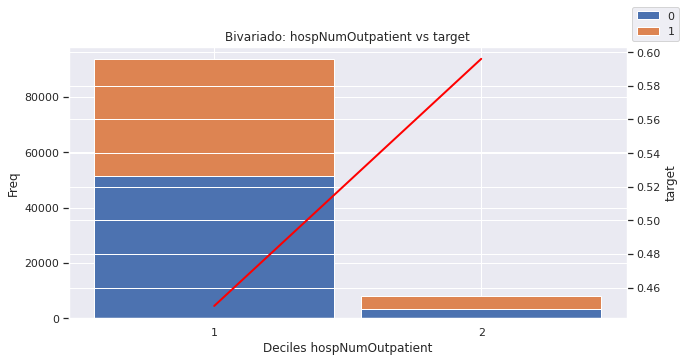

diagNumDiagnoses


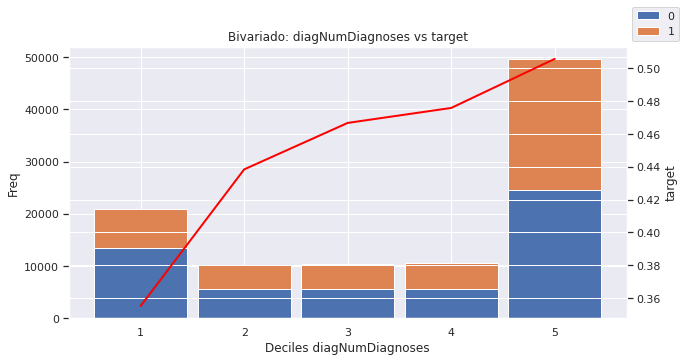

hospNumMedications


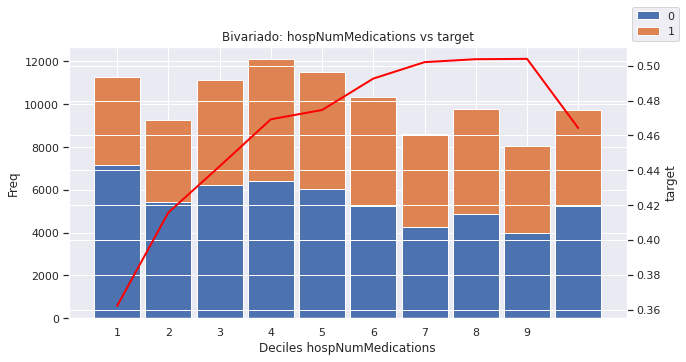

descAdmissionSource


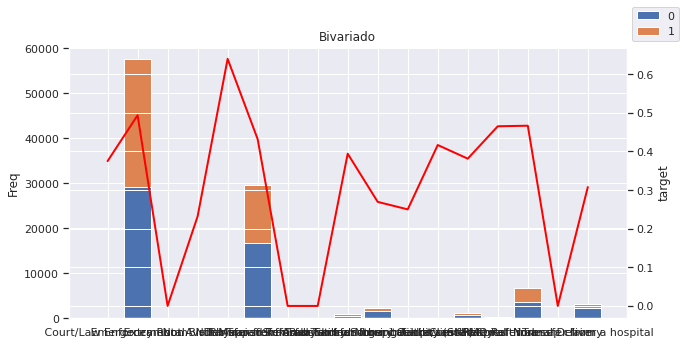

hospTimeHospital


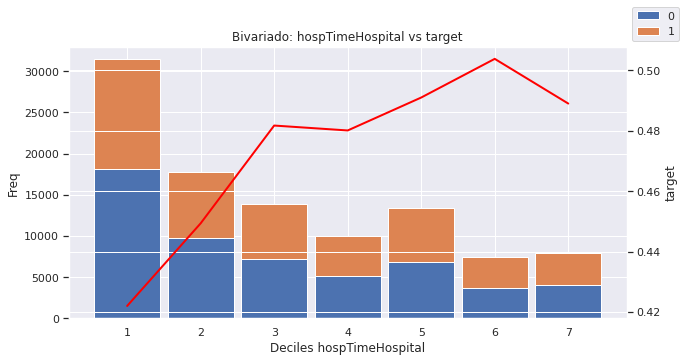

demoAge


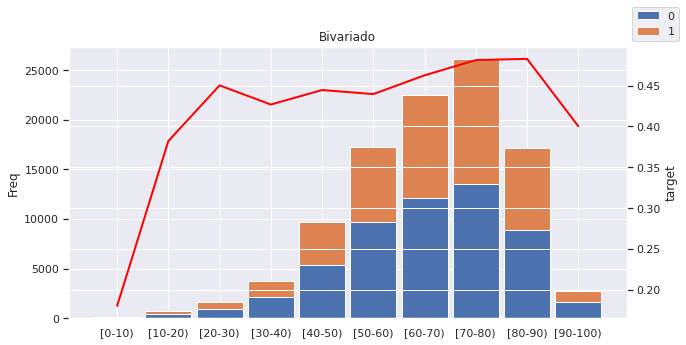

tratDiabetesMed


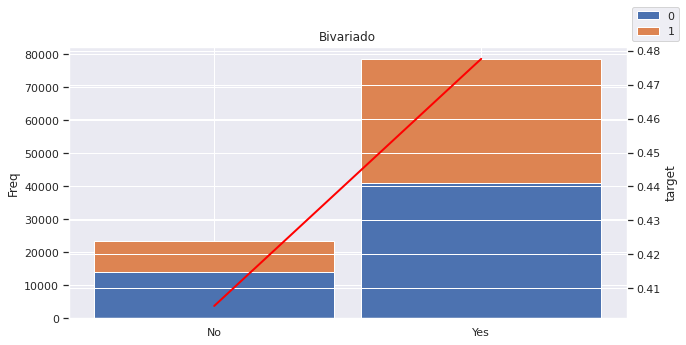

<Figure size 720x360 with 0 Axes>

In [ ]:
plot_graph_bivariable(dfAnalisis, meta, 'target')